# Parameter estimation for a CD-LGSSM using SGD and HMC



## Setup

In [1]:
import sys
from jax import numpy as jnp
import jax.random as jr
from jax import jit, vmap
from functools import partial
from matplotlib import pyplot as plt
%matplotlib inline

# Add our codebase to path
sys.path.append("../../..")
sys.path.append("../..")

# Our codebase
from continuous_discrete_linear_gaussian_ssm import ContDiscreteLinearGaussianSSM as MySSM

# from dynamax.linear_gaussian_ssm import LinearGaussianConjugateSSM as MySSM
from dynamax.utils.utils import monotonically_increasing

/opt/homebrew/anaconda3/envs/hduq_nodynamax/lib/python3.11/site-packages/equinox/_ad.py:733: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(


## Data



Sampling from transition distribution (this may be a poor approximation if you're simulating from a non-linear SDE). It is a highly appropriate choice for linear SDEs.


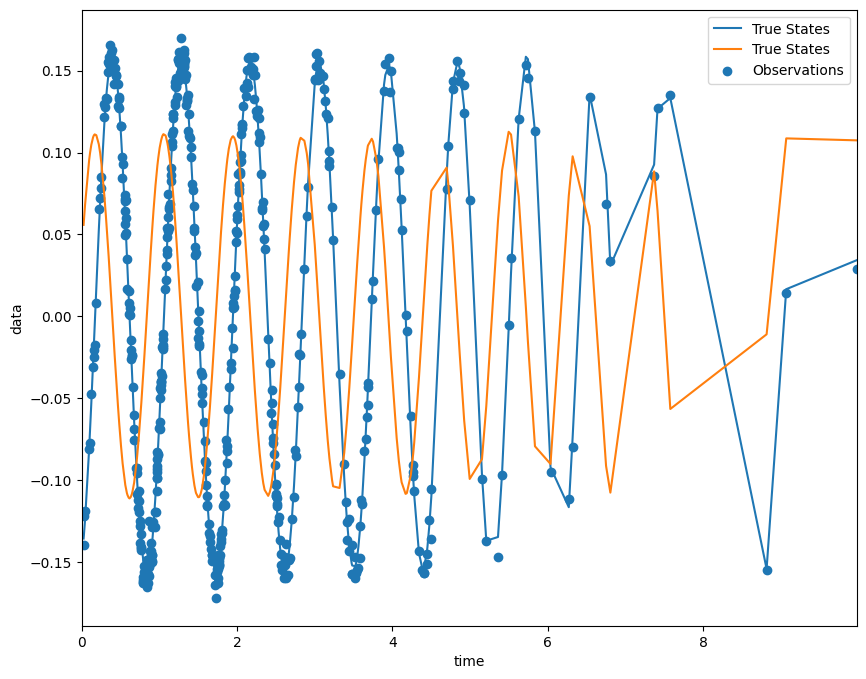

In [2]:
state_dim=2
emission_dim=1
num_timesteps=500
key = jr.PRNGKey(0)

# Parameter definition
initial_mean = jnp.array([0.0, 0.0])
initial_covariance = jnp.eye(state_dim) * 0.1
dynamics_weights  = jnp.array([[0.0, 10.0],
                               [-5.0, 0.0]])
dynamics_diffusion_covariance = jnp.eye(state_dim) * 0.0001
# Only observe first state
emission_weights = jnp.array([[1.0, 0]])
emission_covariance = jnp.eye(emission_dim) * 0.00005

# Model definition: MySSM is a CD-LGSSM
true_model = MySSM(state_dim, emission_dim)
key, key_root = jr.split(key)
true_params, param_props = true_model.initialize(key,
                                        initial_mean=initial_mean,
                                        initial_cov=initial_covariance,
                                        dynamics_weights=dynamics_weights,
                                        dynamics_diffusion_cov=dynamics_diffusion_covariance,
                                        emission_weights=emission_weights,
                                        emission_cov=emission_covariance
                                    )

# irregular sampling schedule
def generate_sorted_gamma_array(N, shape_param, scale_param, rng_key):
    # Generate random values from a gamma distribution.
    gamma_values = jr.gamma(rng_key, shape_param, shape=(N,)) * scale_param
    # Sort the array.
    sorted_values = jnp.sort(gamma_values)
    return sorted_values

shape_param = 2.0  # Shape parameter of the gamma distribution
scale_param = 1.0  # Scale parameter of the gamma distribution
rng_key = jr.PRNGKey(0)  # Initialize a random key
t_emissions = generate_sorted_gamma_array(num_timesteps, shape_param, scale_param, rng_key)
# print(t_emissions)
t_emissions = t_emissions[:,None]

# Data generation from true model, at specified sampling times
key, key_root = jr.split(key)
true_states, emissions = true_model.sample(true_params, key,
                                            num_timesteps=num_timesteps,
                                            t_emissions=t_emissions
                                          )

# Plot the true states and emissions
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(t_emissions, true_states, label='True States')
ax.scatter(t_emissions, emissions, label='Observations')
ax.set_ylabel("data")
ax.set_xlabel("time")
ax.set_xlim(0, t_emissions[-1])
ax.legend()

## Plot results

In [3]:
def plot_learning_curve(marginal_lls, true_model, true_params, test_model, test_params, emissions, t_emissions):
    plt.figure()
    plt.xlabel("iteration")
    nsteps = len(marginal_lls)
    plt.plot(marginal_lls, label="estimated")
    true_logjoint = (
        true_model.log_prior(true_params) \
            + true_model.marginal_log_prob(
                true_params,
                emissions,
                t_emissions)
    )
    plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
    plt.ylabel("marginal joint probability")

    # Adjust y-axis limits
    y_min = min(min(marginal_lls), true_logjoint) * 1.1  # 10% lower than the smallest value
    y_max = max(max(marginal_lls), true_logjoint) * 1.1  # 10% higher than the largest value
    plt.ylim([y_min, y_max])
    plt.yscale('symlog')
    plt.autoscale(enable=True, axis="x", tight=True)
    plt.legend()

In [4]:
def plot_scalar(true_val, test_val, title):
    plt.figure()
    plt.bar(["True", "Test"], [true_val, test_val])
    plt.title(title)
    plt.ylabel("Value")
    plt.show()

def plot_vector(true_val, test_val, title):
    x = jnp.arange(len(true_val))
    width = 0.35

    plt.figure()
    plt.bar(x - width/2, true_val, width, label='True')
    plt.bar(x + width/2, test_val, width, label='Test')
    plt.title(title)
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.show()

def plot_matrix(matrix, title):
    plt.figure()
    plt.imshow(matrix, cmap='viridis', aspect='auto')
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

def compare_parameters(true_params, test_params):
    for level_key, inner_tuple in true_params._asdict().items():
        for param_key, true_value in inner_tuple._asdict().items():
            test_value = getattr(getattr(test_params, level_key), param_key)

            title = f"{level_key} - {param_key}"
            if jnp.isscalar(true_value):
                plot_scalar(true_value, test_value, title)
            elif true_value.ndim == 1:
                plot_vector(true_value, test_value, title)
            elif true_value.ndim == 2:
                plot_matrix(true_value, title + " (True Matrix)")
                plot_matrix(test_value, title + " (Test Matrix)")

                # Vectorize matrices and plot
                true_vectorized = true_value.flatten()
                test_vectorized = test_value.flatten()
                plot_vector(true_vectorized, test_vectorized, title + " (Vectorized)")    

In [5]:
def plot_states(true_states, estimated_states_mean, estimated_states_cov, t_emissions):
    t_emissions = t_emissions.squeeze()
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(true_states.shape[1]):
        plt.plot(
            t_emissions,
            true_states[:, i] + spc * i,
            "--k",
            label="True state {}".format(i)
        )
        ln = plt.plot(
            t_emissions,
            estimated_states_mean[:, i] + spc * i,
            label="Estimated state {}".format(i)
        )[0]
        plt.fill_between(
            t_emissions,
            spc * i + estimated_states_mean[:, i] - 2 * jnp.sqrt(estimated_states_cov[:,i,i]),
            spc * i + estimated_states_mean[:, i] + 2 * jnp.sqrt(estimated_states_cov[:,i,i]),
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, t_emissions[-1])
    plt.ylabel("true and estimated states")
    plt.legend()
    plt.show()

In [6]:
def plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions):
    # run the smoother w/ test_params on emissions data
    smoothed_emissions, smoothed_emissions_std = test_model.posterior_predictive(
        test_params,
        emissions,
        t_emissions
    )

    t_emissions = t_emissions.squeeze()
    spc = 3
    plt.figure(figsize=(10, 4))
    for i in range(emission_dim):
        plt.plot(t_emissions, emissions[:, i] + spc * i, "--k", label="observed" if i == 0 else None)
        ln = plt.plot(t_emissions, smoothed_emissions[:, i] + spc * i,
                        label="smoothed" if i == 0 else None)[0]
        plt.fill_between(
            t_emissions,
            spc * i + smoothed_emissions[:, i] - 2 * smoothed_emissions_std[i],
            spc * i + smoothed_emissions[:, i] + 2 * smoothed_emissions_std[i],
            color=ln.get_color(),
            alpha=0.25,
        )
    plt.xlabel("time")
    plt.xlim(0, t_emissions[-1])
    plt.ylabel("true and predicted emissions")
    plt.legend()
    plt.show()

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


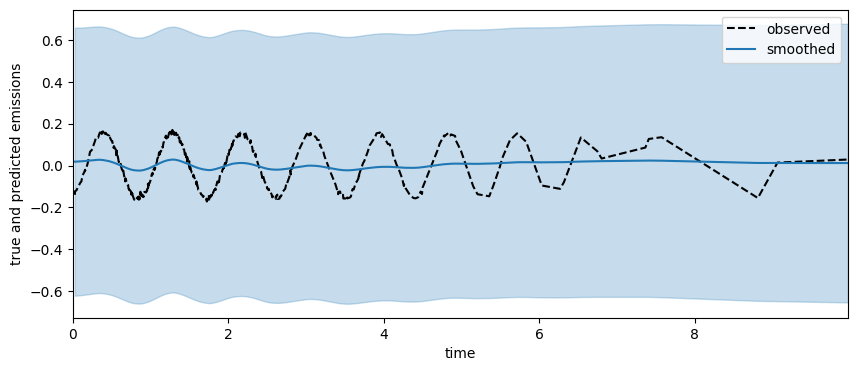

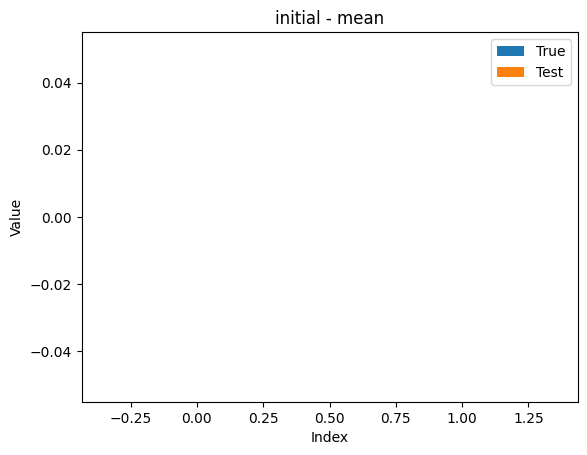

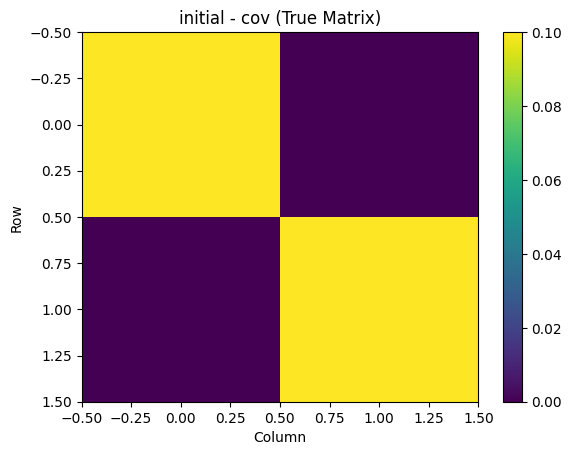

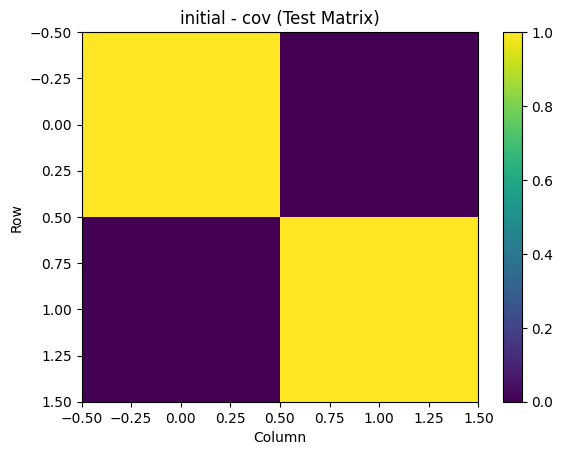

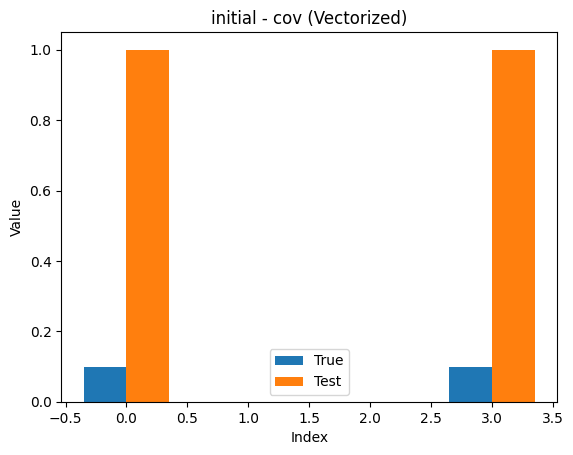

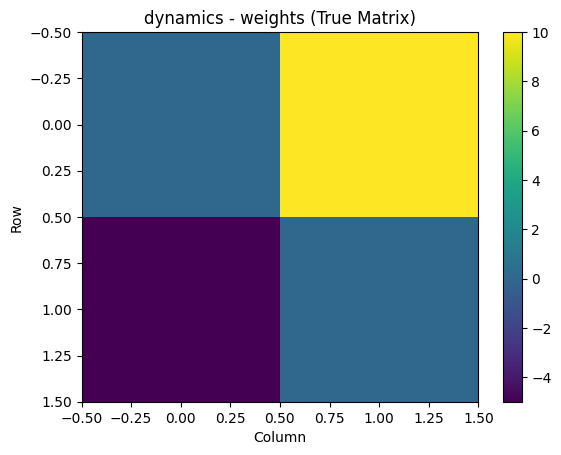

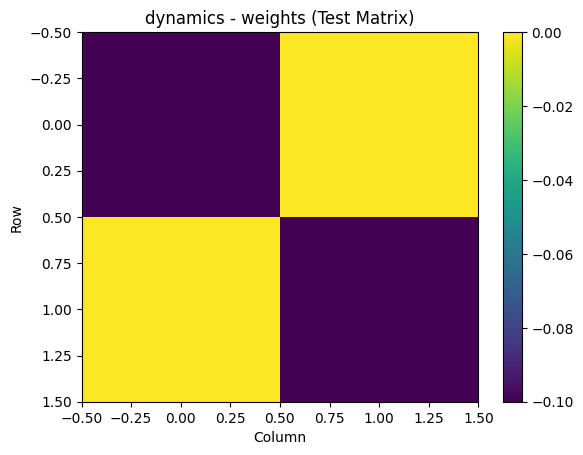

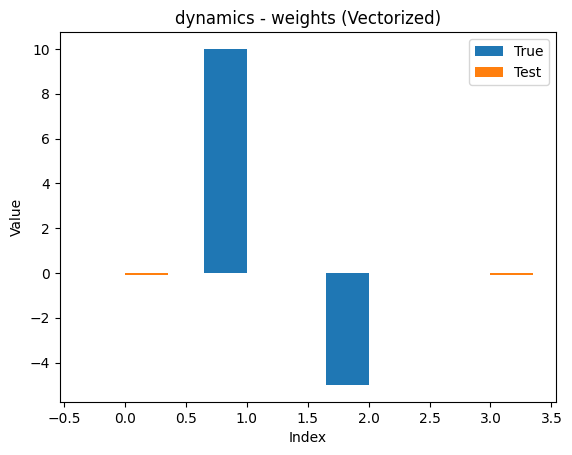

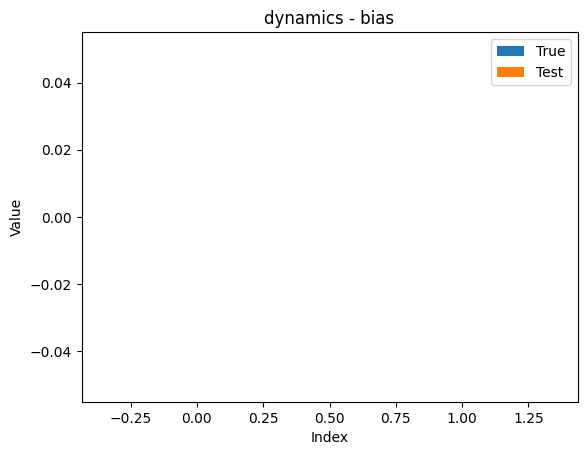

/var/folders/50/1p5n7hj54qzcm4nkffdzb70m0000gq/T/ipykernel_45467/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


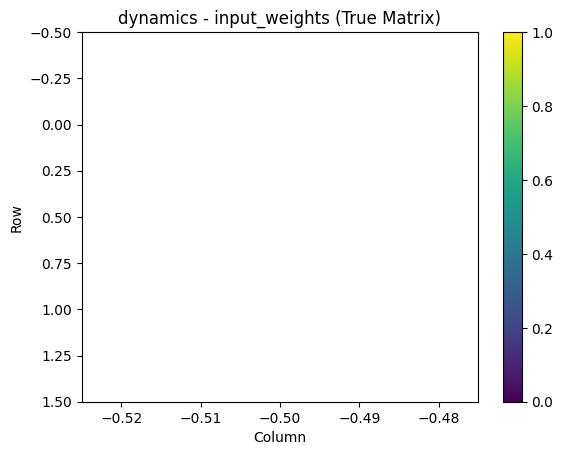

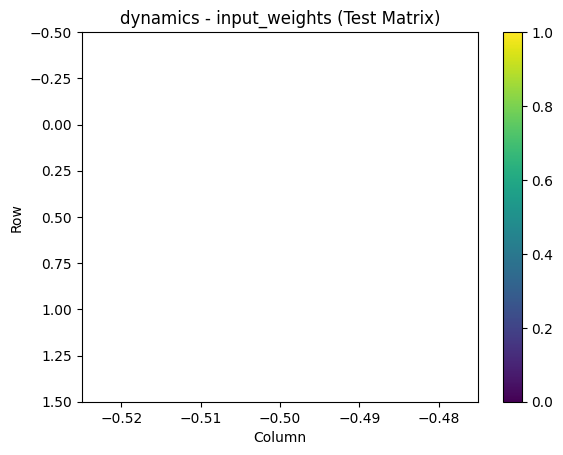

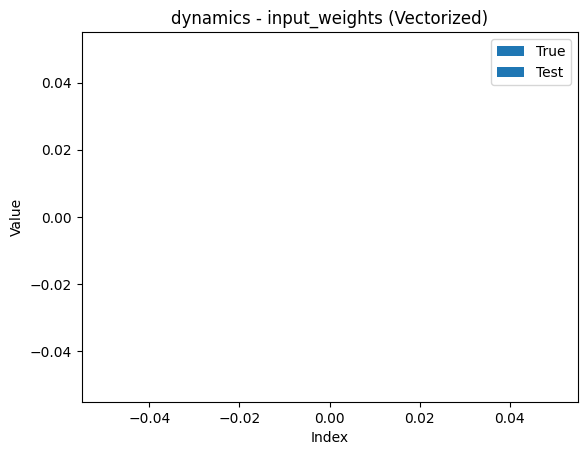

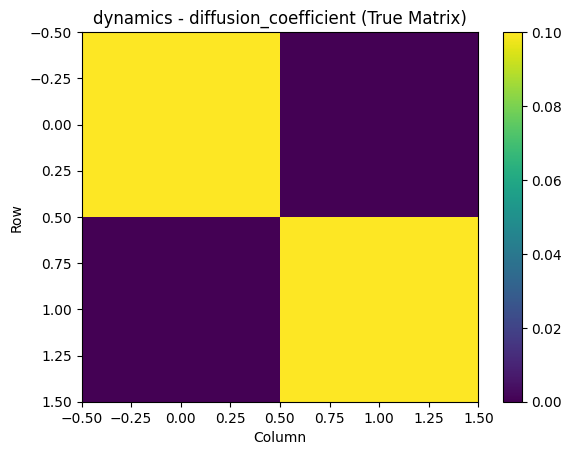

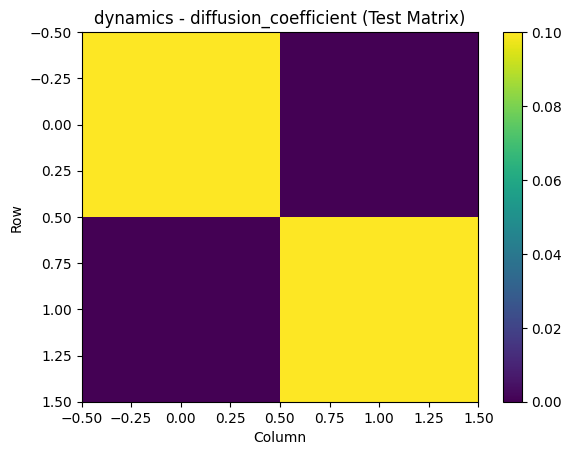

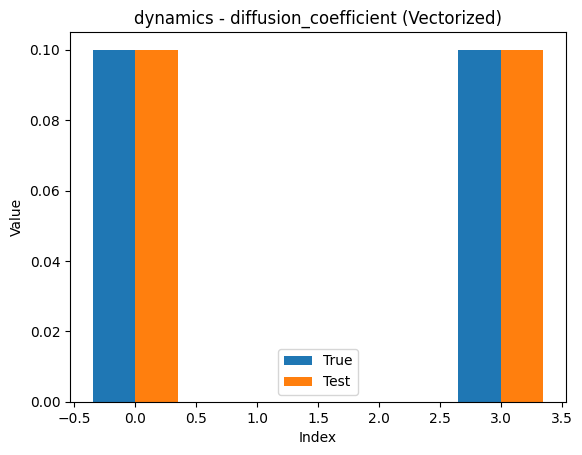

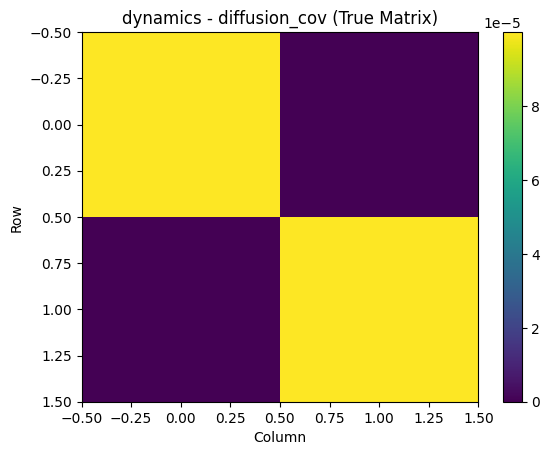

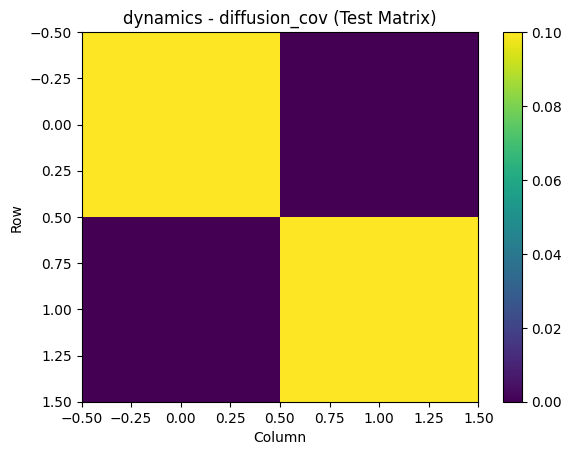

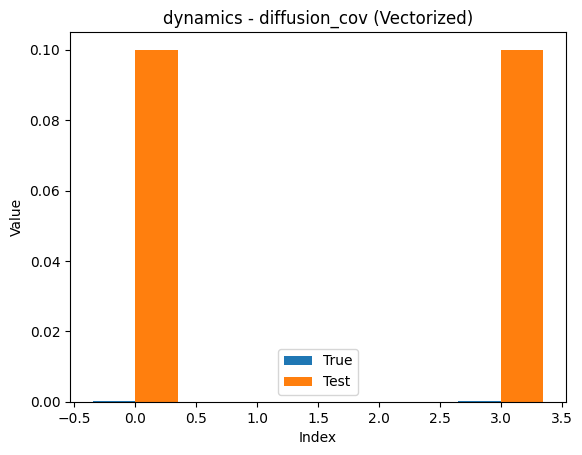

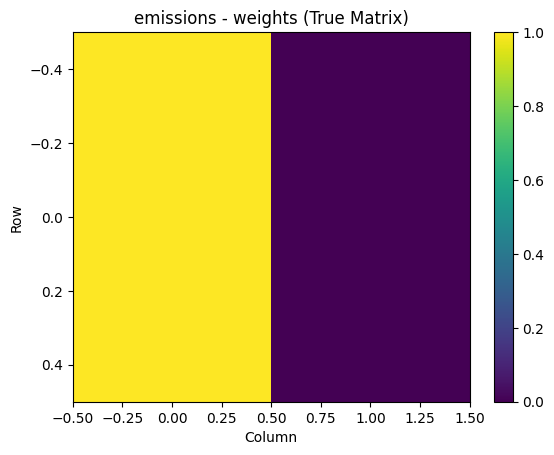

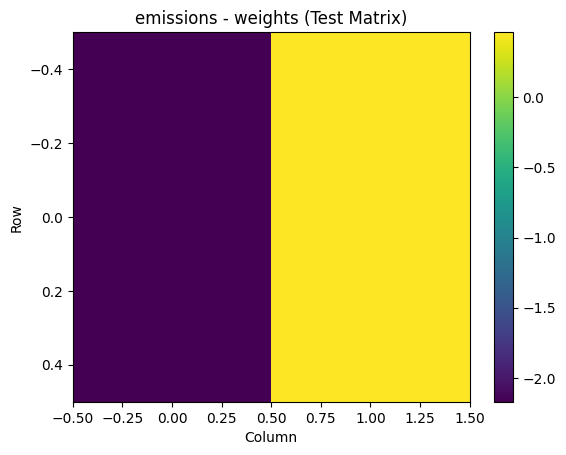

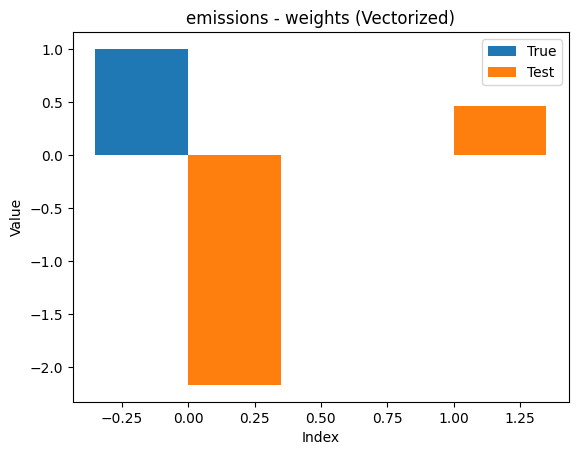

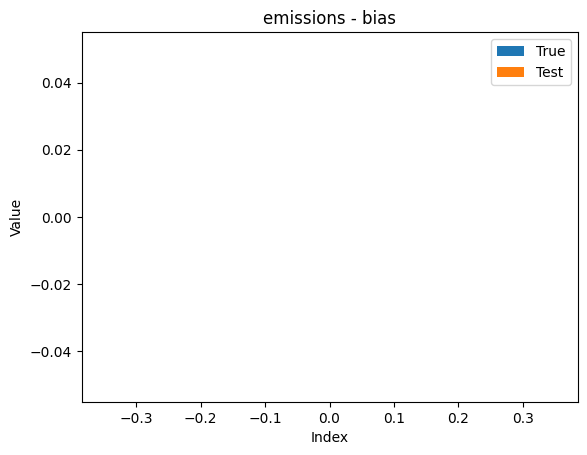

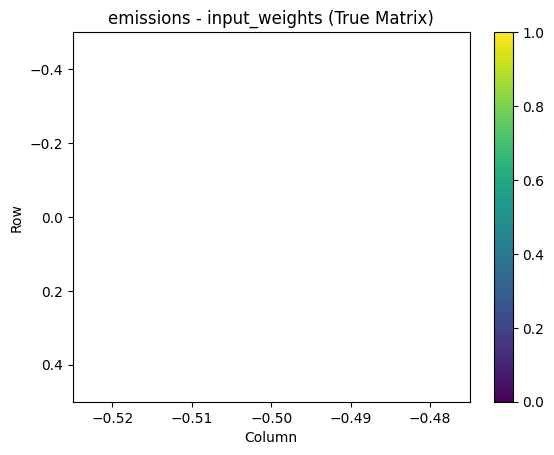

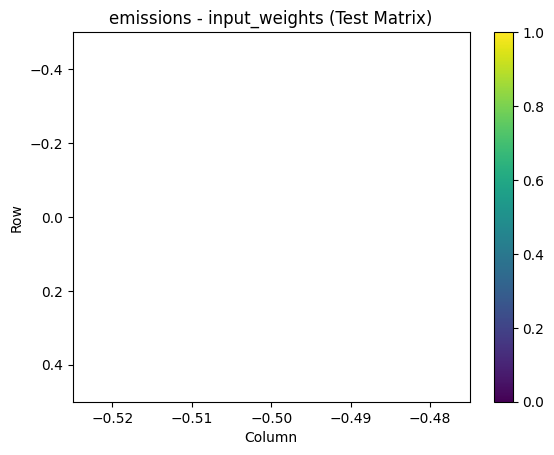

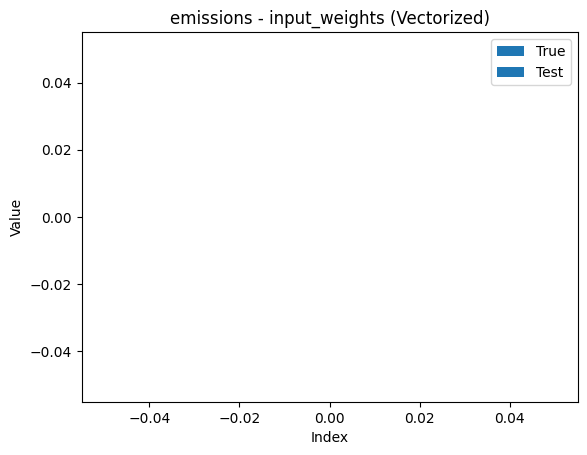

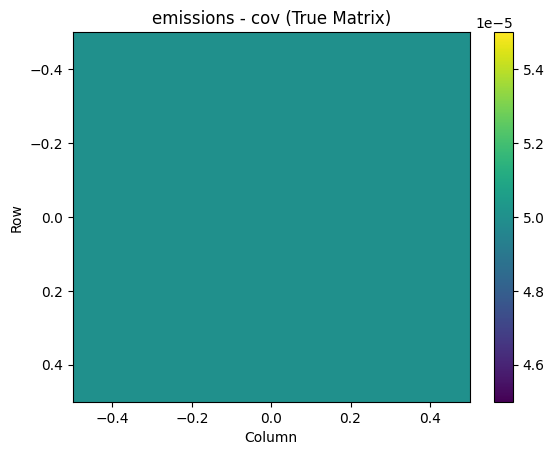

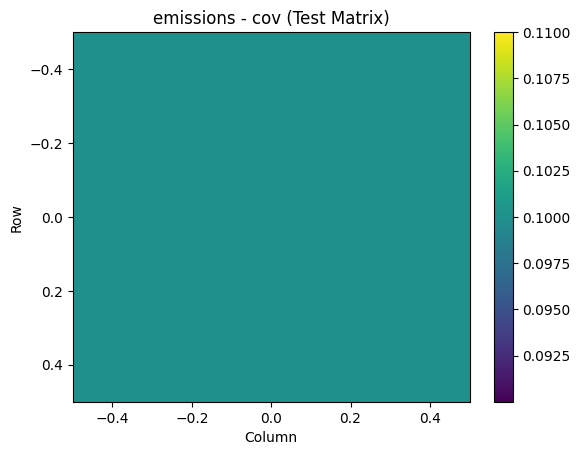

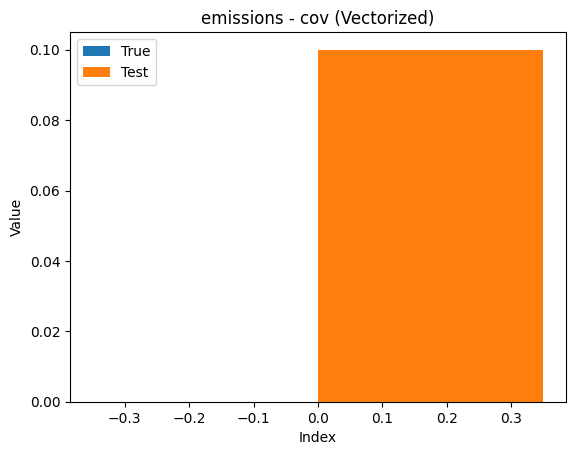

In [7]:
# Plot predictions from a random, untrained model
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
test_params, param_props = test_model.initialize(key)

plot_predictions(true_model, true_params, test_model, test_params, emissions, t_emissions)
compare_parameters(true_params, test_params)

## Fit with SGD

## Define model to fit, and let default SGD find the MLE

In [8]:
# Define new model, with different key seeding
new_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
new_params, param_props = new_model.initialize(key)

# Fit model with default filtering
num_epochs = 5000
fitted_new_params, neg_marginal_lls = new_model.fit_sgd(
    new_params,
    param_props,
    emissions,
    t_emissions,
    num_epochs=num_epochs
)
# Note that fit_sgd returns normalized negative log-likelihoods
# So simply multiply by number of datapoints in emissions
marginal_lls = -neg_marginal_lls * emissions.size

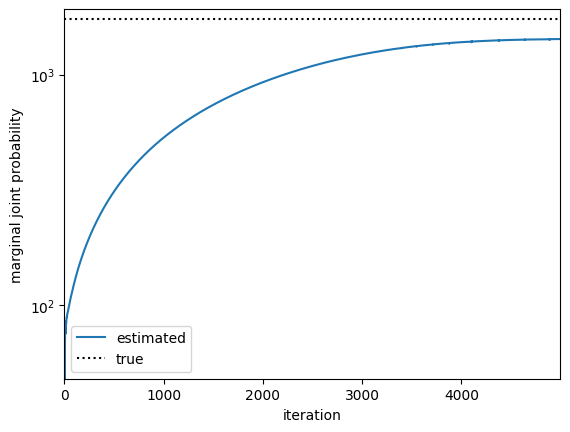

In [9]:
# Learning curve
plot_learning_curve(
    marginal_lls,
    true_model,
    true_params,
    new_model,
    fitted_new_params,
    emissions,
    t_emissions,
)

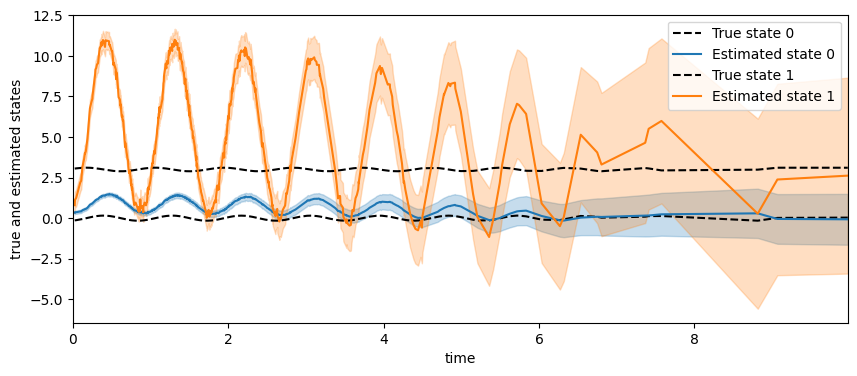

In [10]:
filtered_posterior=new_model.filter(fitted_new_params,emissions=emissions,t_emissions=t_emissions)
plot_states(
    true_states,
    filtered_posterior.filtered_means,
    filtered_posterior.filtered_covariances,
    t_emissions,
)

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


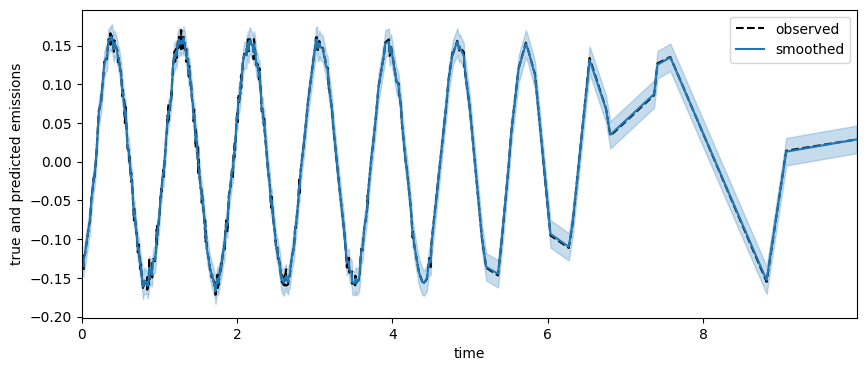

In [11]:
plot_predictions(
    true_model,
    true_params,
    test_model,
    fitted_new_params,
    emissions,
    t_emissions
)


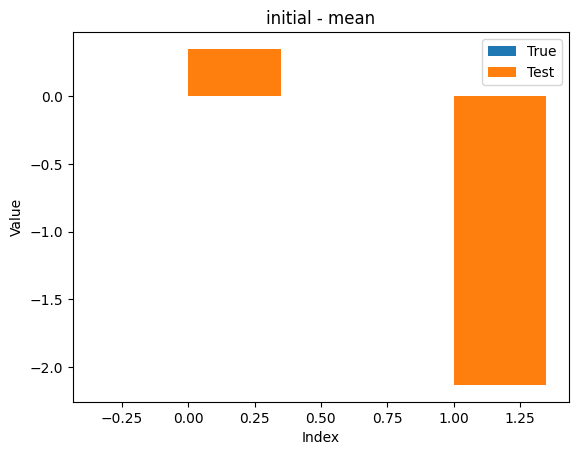

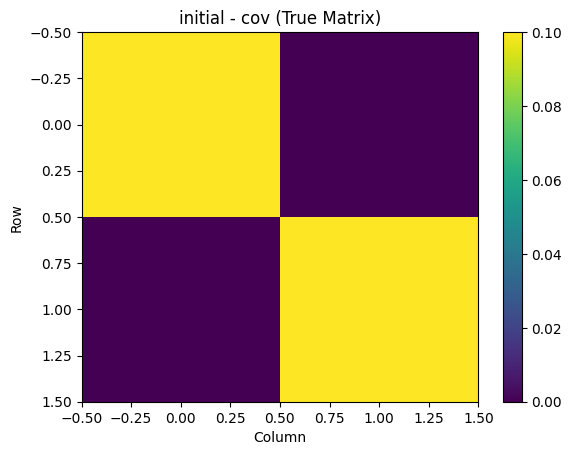

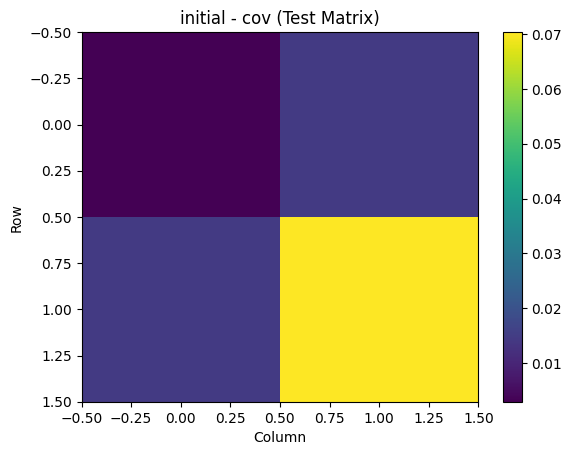

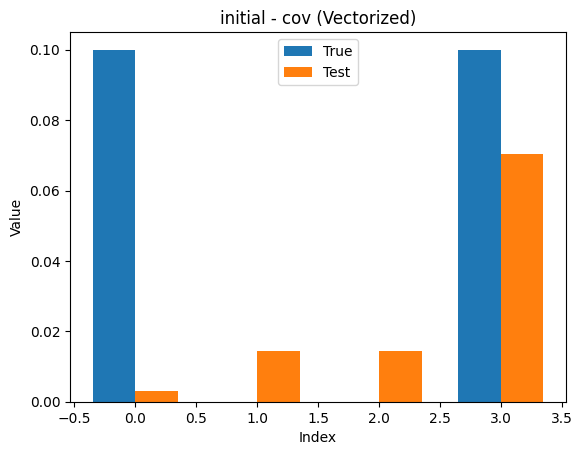

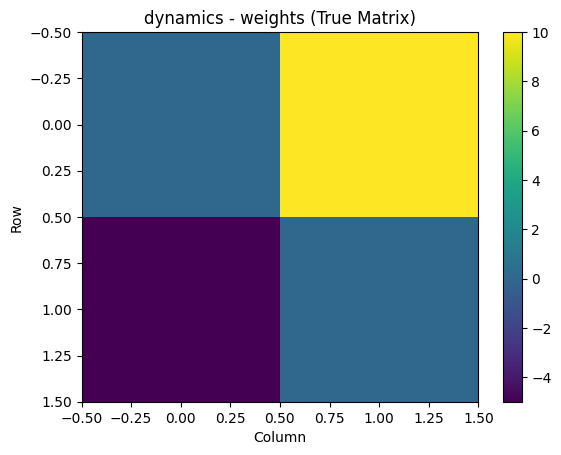

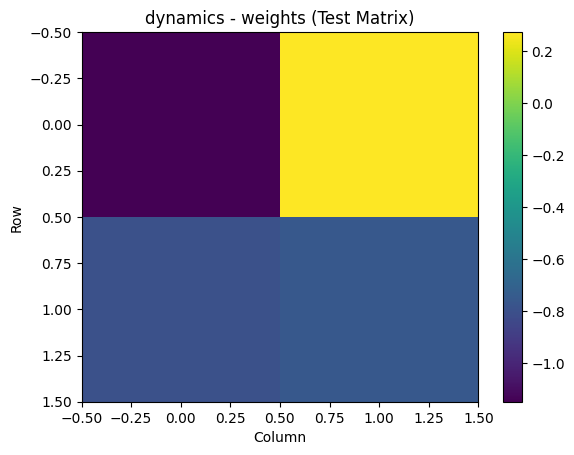

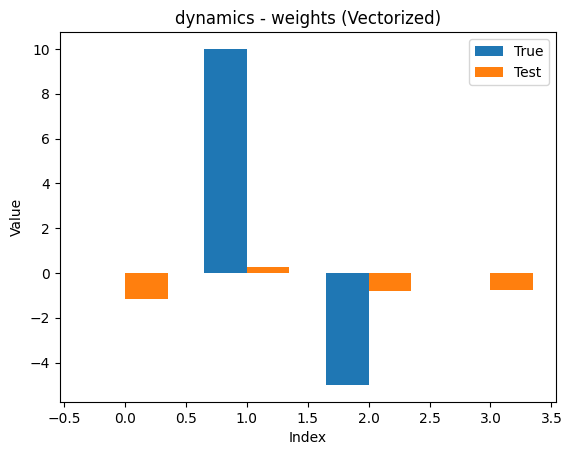

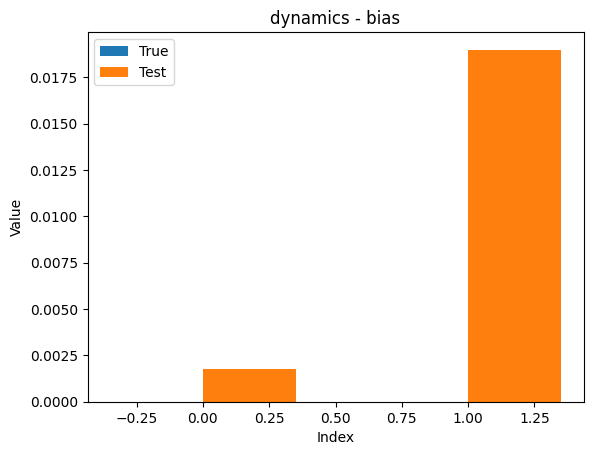

/var/folders/50/1p5n7hj54qzcm4nkffdzb70m0000gq/T/ipykernel_45467/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


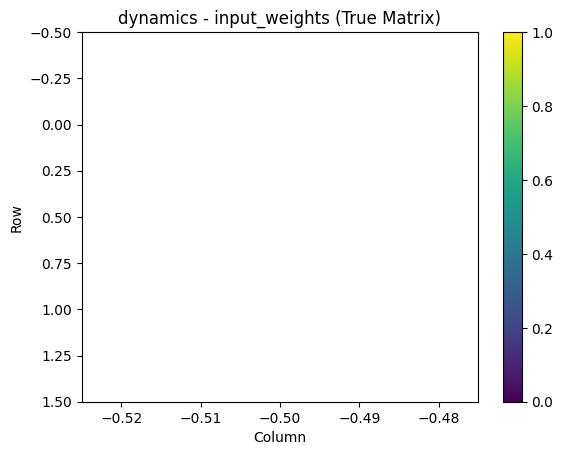

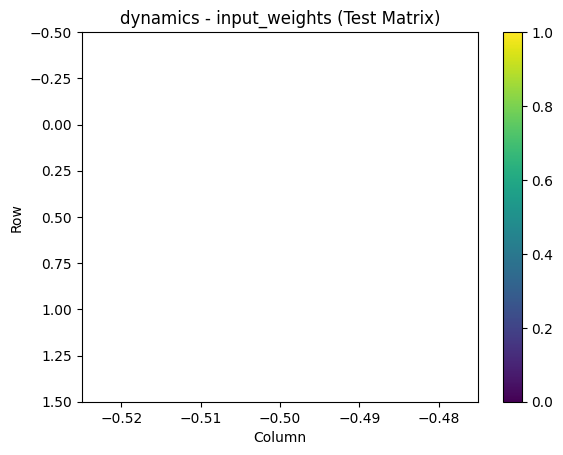

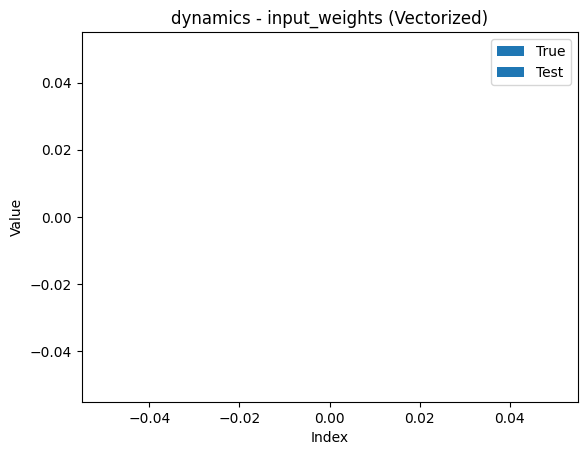

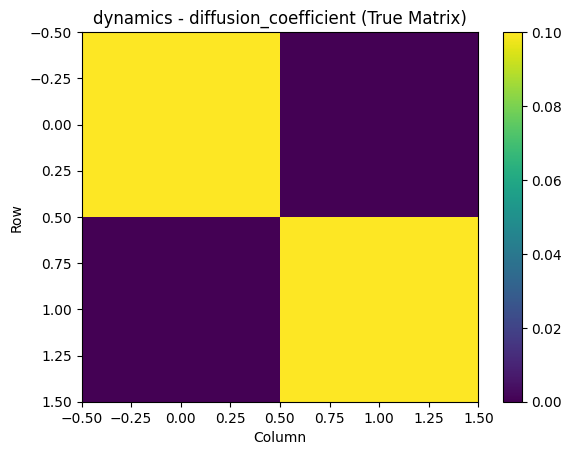

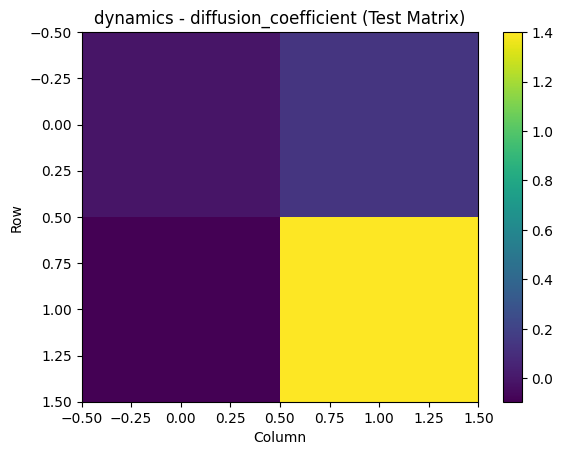

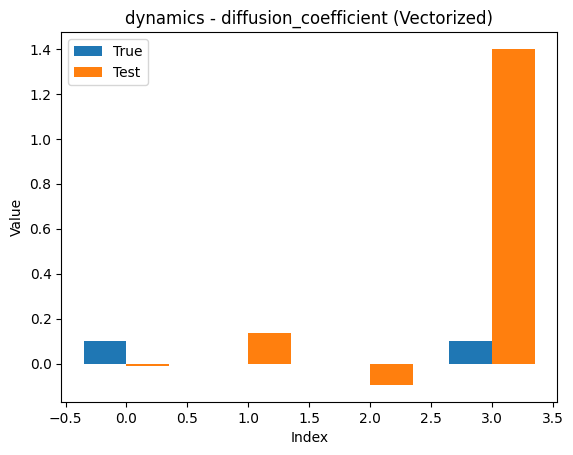

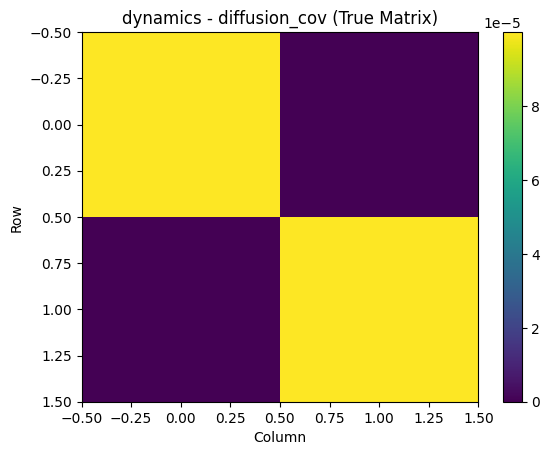

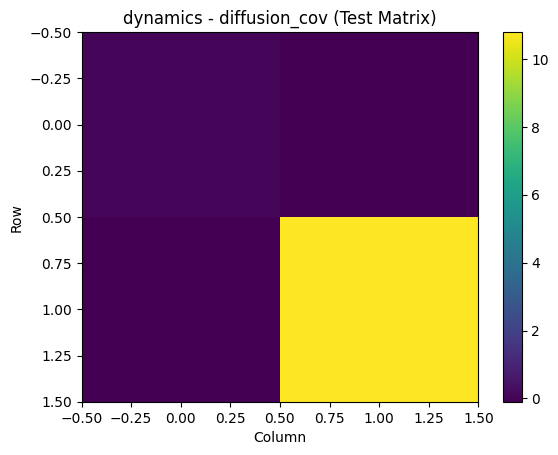

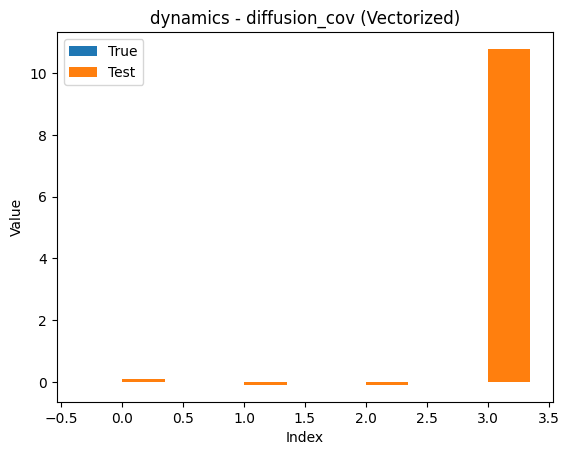

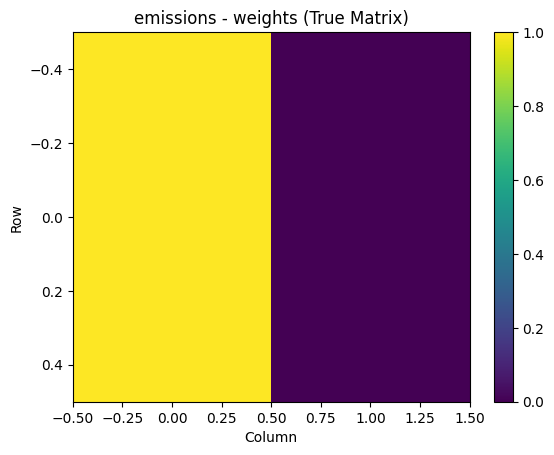

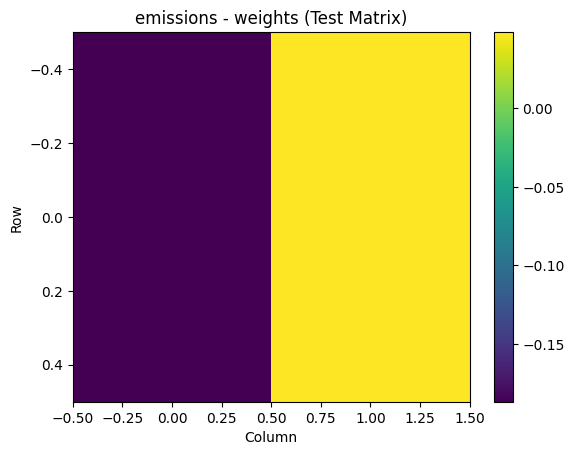

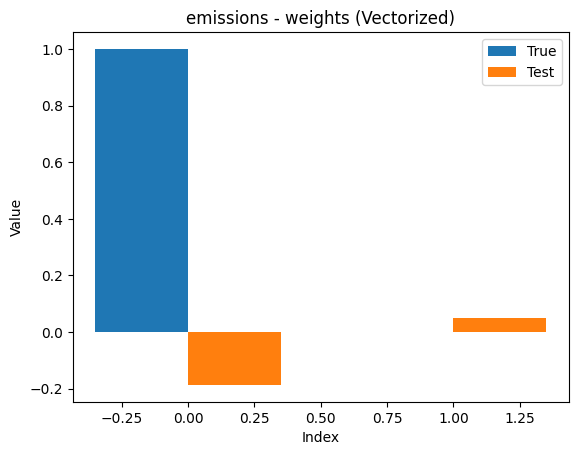

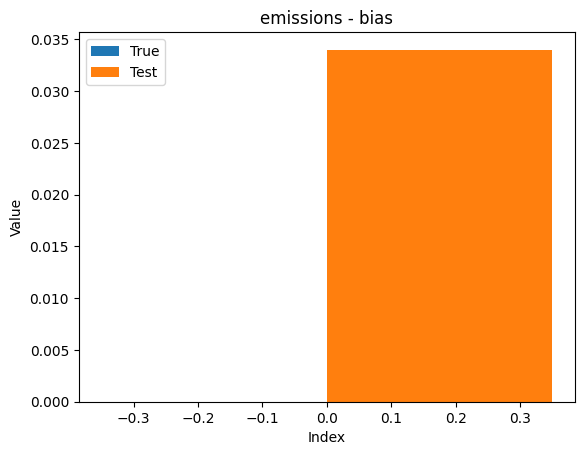

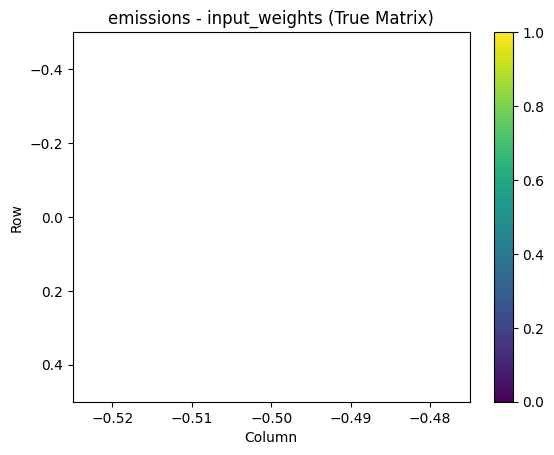

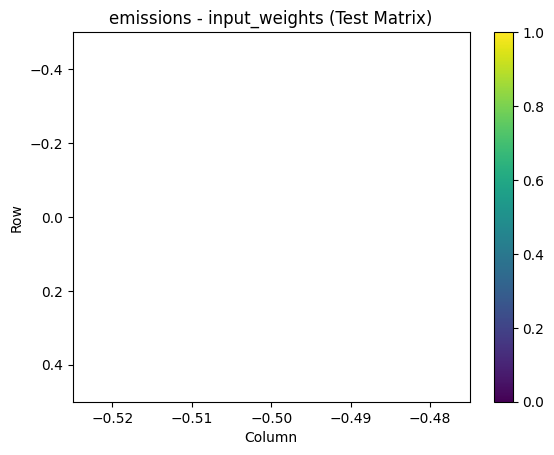

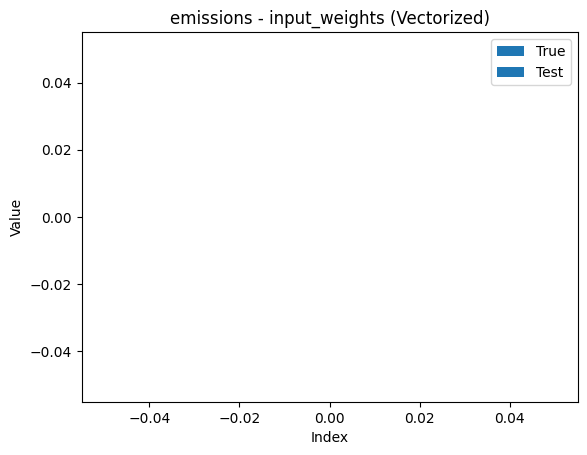

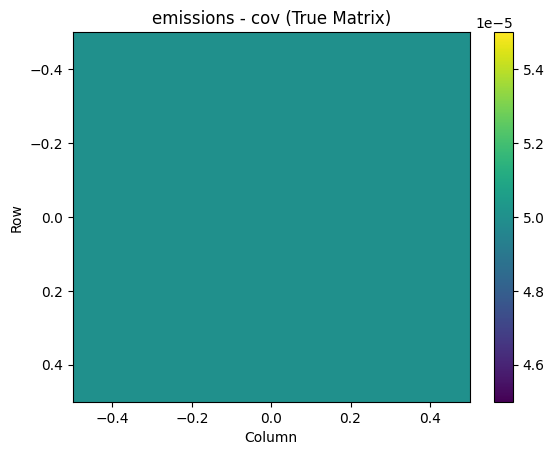

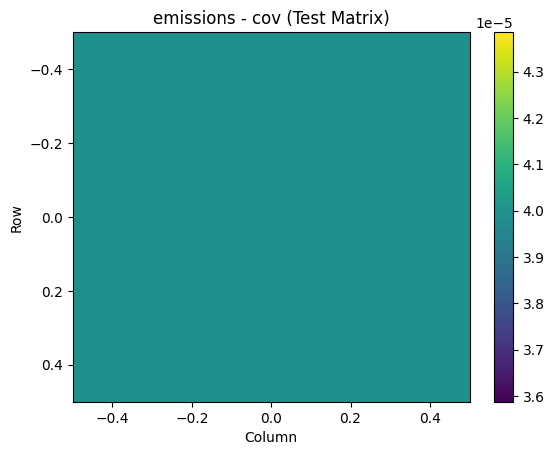

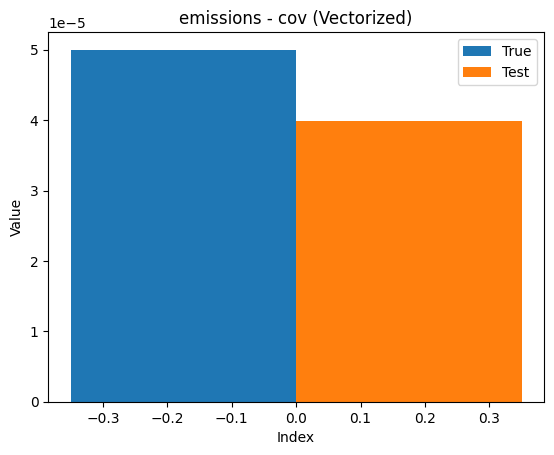

In [12]:
compare_parameters(
    true_params,
    fitted_new_params
)

## Define new model to fit, and define a new SGD optimizer to find the MLE

In [13]:
# Define new SGD scheduler: exponential decay
import optax
def create_adam_optimizer_with_schedule(initial_learning_rate, decay_steps, decay_rate):
    # Create the learning rate scheduler: exponential decay
    lr_schedule = optax.exponential_decay(
        init_value=initial_learning_rate,  # Initial learning rate
        transition_steps=decay_steps,      # Steps after which to apply decay
        decay_rate=decay_rate              # Decay rate
    )

    # Adam optimizer with above learning rate scheduler
    optimizer = optax.chain(
        optax.scale_by_adam(),  # Adam updates
        optax.scale_by_schedule(lr_schedule),  # Scale updates according to the schedule
        optax.scale(-1.0)  # Apply the negative sign for gradient descent
    )
    return optimizer

In [14]:
# Set-up SGD optimizer: ADAM with lr schedule
initial_learning_rate = 2e-2
decay_steps = 250
decay_rate = 0.5
optimizer = create_adam_optimizer_with_schedule(
    initial_learning_rate,
    decay_steps,
    decay_rate
)

In [15]:
# Define new model, with different key seeding
test_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
test_params, param_props = test_model.initialize(key)

# Fit model with default filtering
num_epochs = 500
fitted_params, neg_marginal_lls = test_model.fit_sgd(
    test_params,
    param_props,
    emissions,
    t_emissions,
    optimizer=optimizer,
    num_epochs=num_epochs
)
# Note that fit_sgd returns normalized negative log-likelihoods
# So simply multiply by number of datapoints in emissions
marginal_lls = -neg_marginal_lls * emissions.size

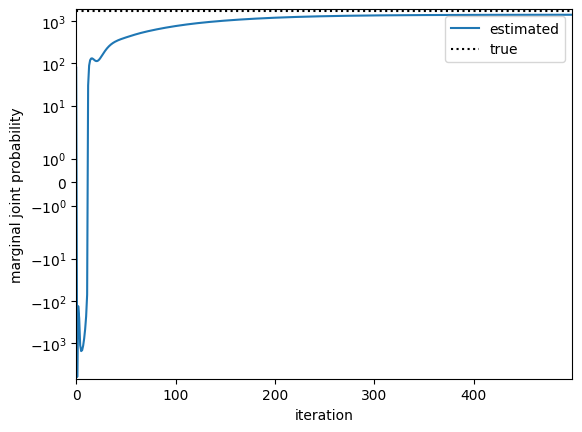

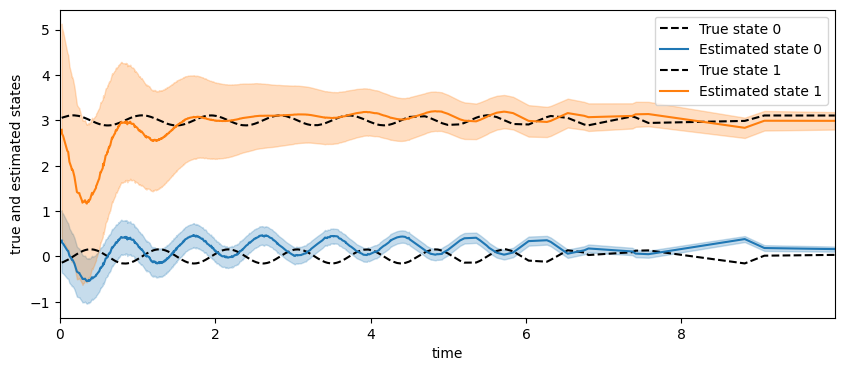

Running KF smoother type = cd_smoother_1
Running KF smoother type 1


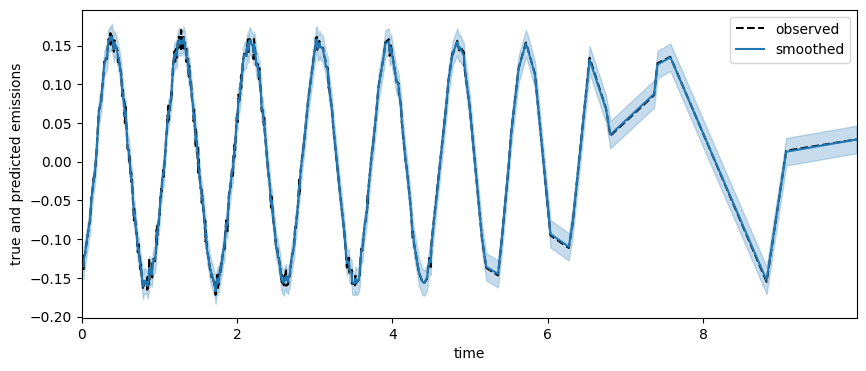

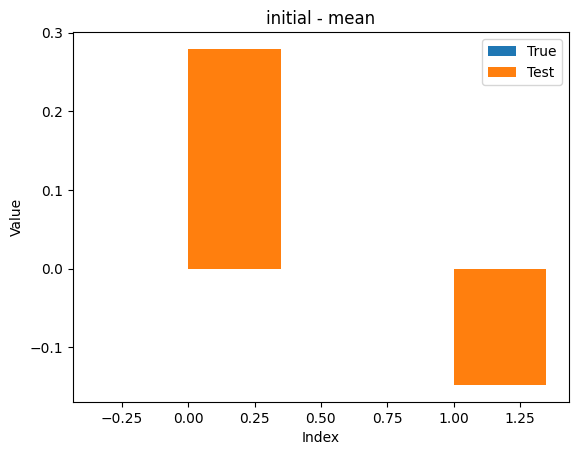

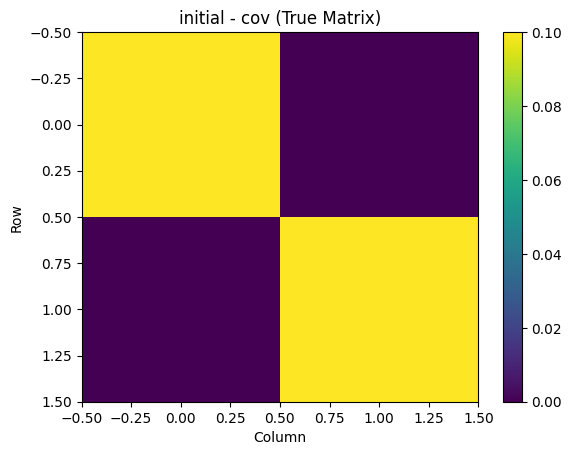

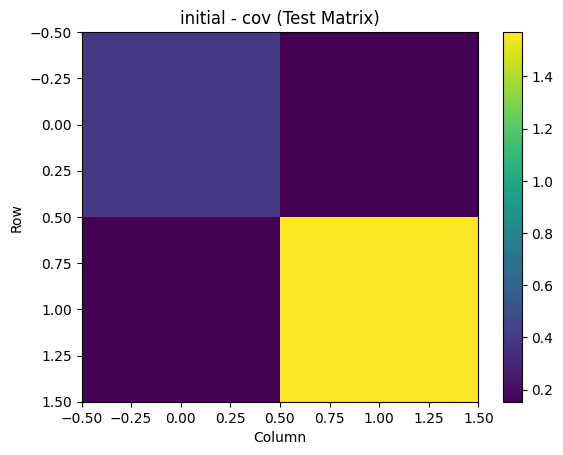

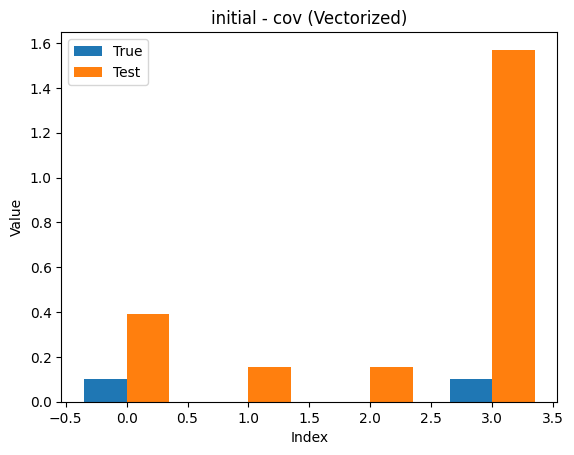

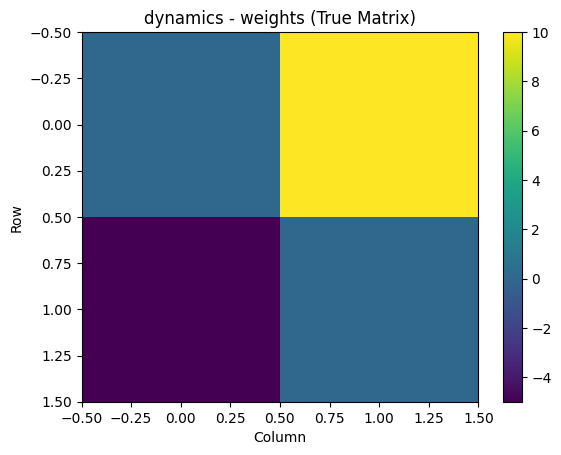

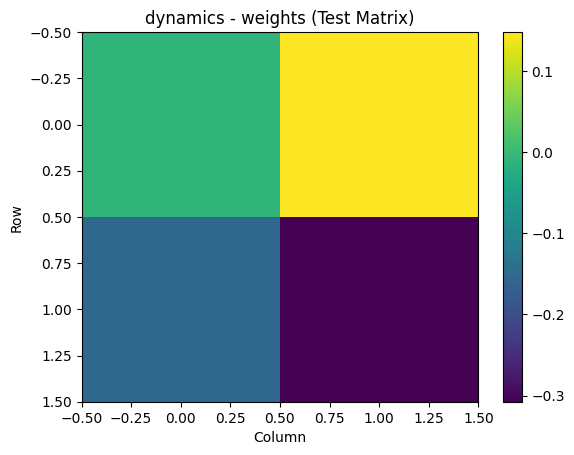

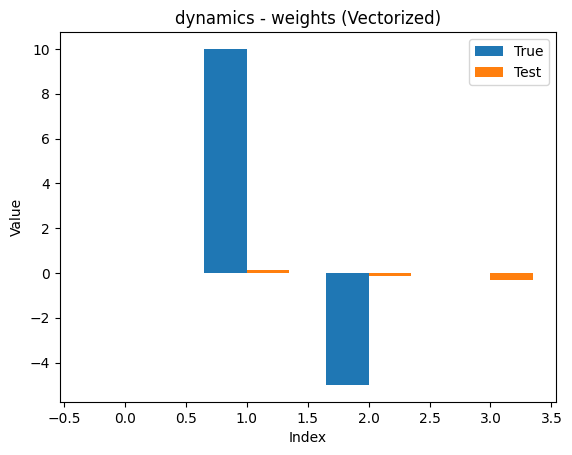

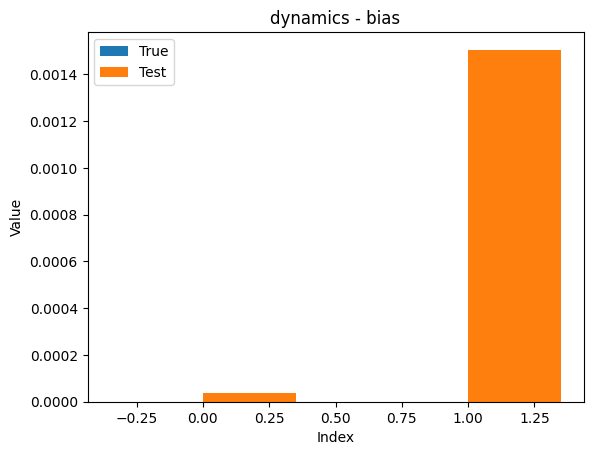

/var/folders/50/1p5n7hj54qzcm4nkffdzb70m0000gq/T/ipykernel_45467/951752220.py:23: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  plt.imshow(matrix, cmap='viridis', aspect='auto')


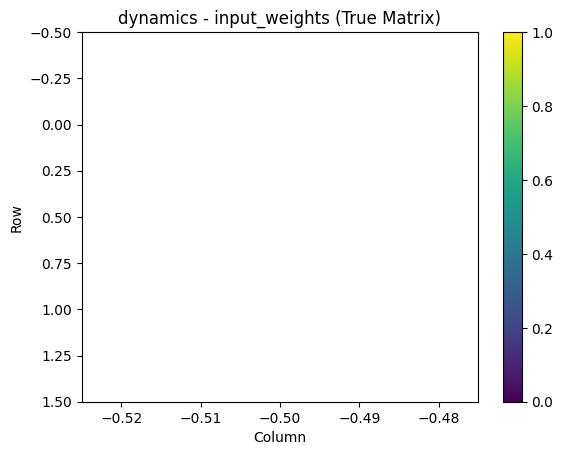

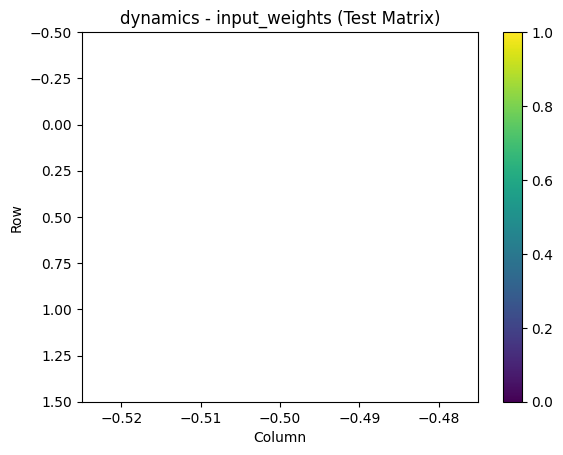

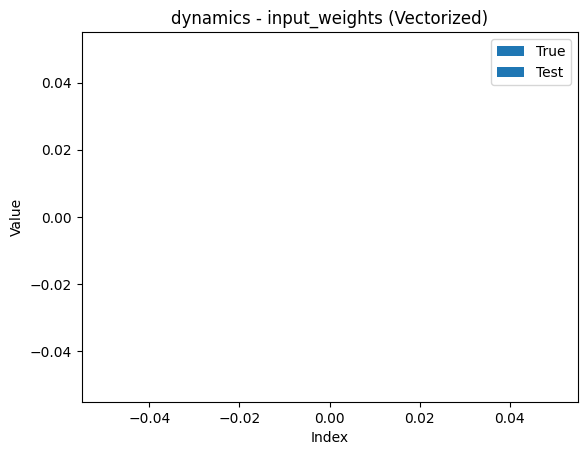

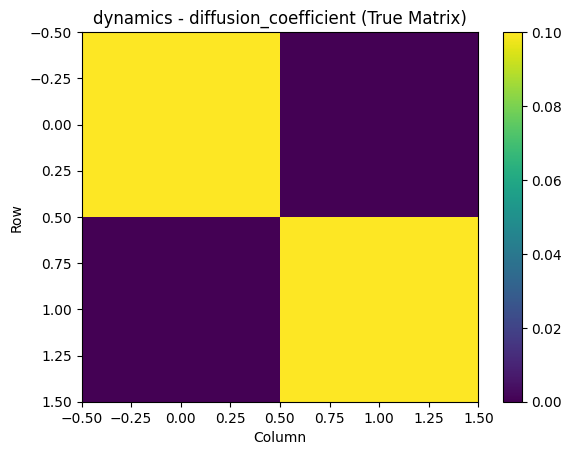

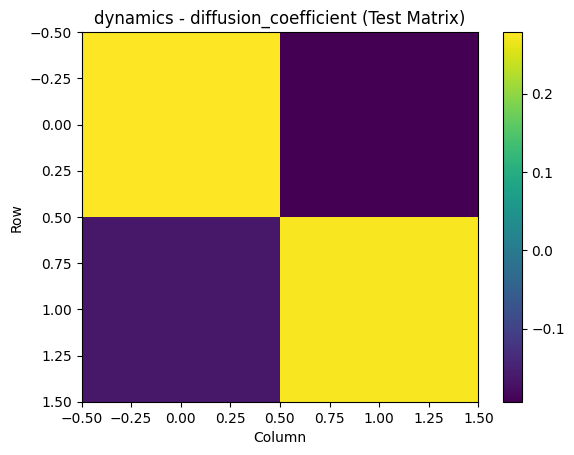

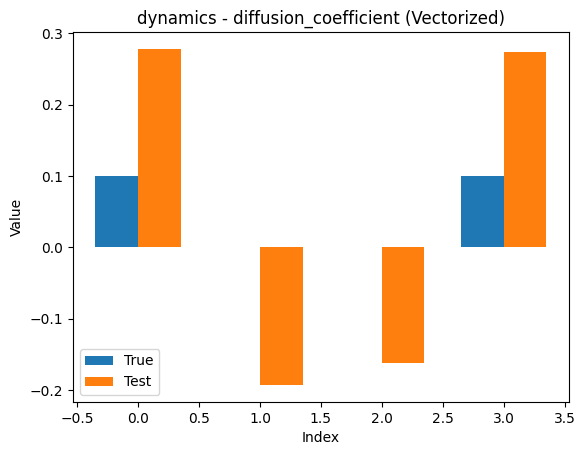

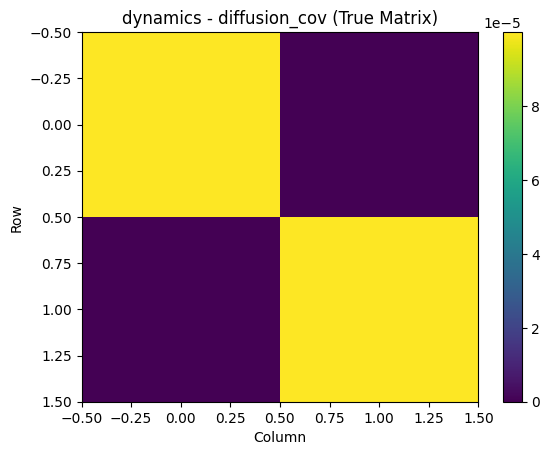

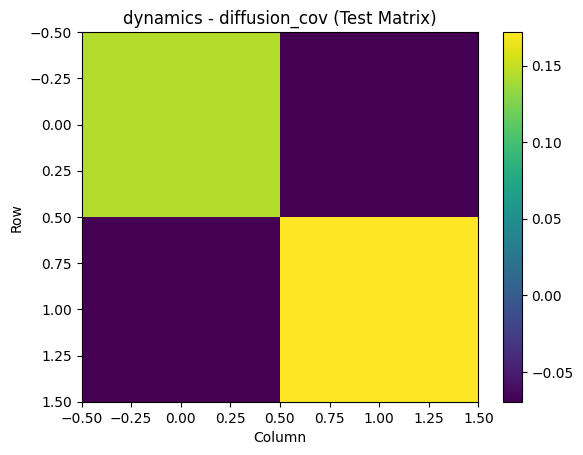

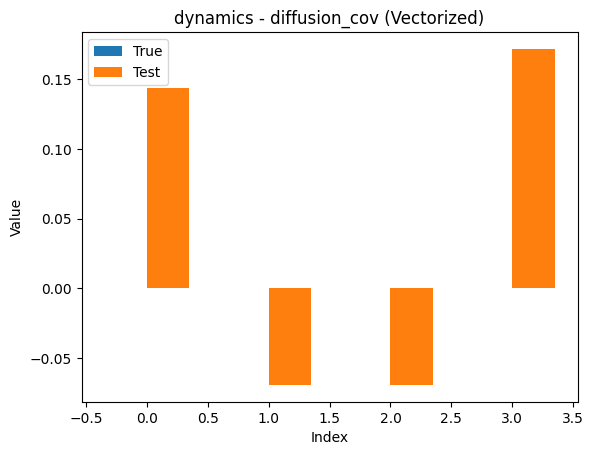

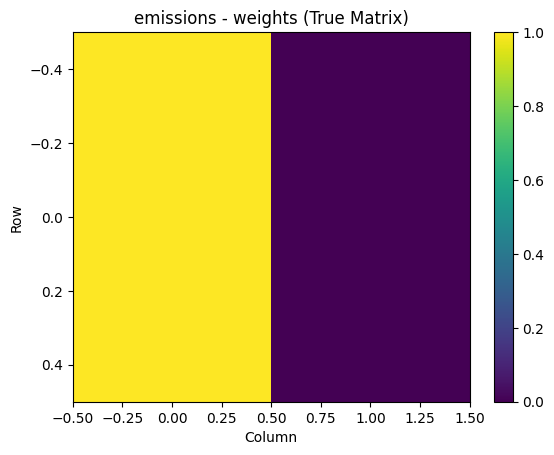

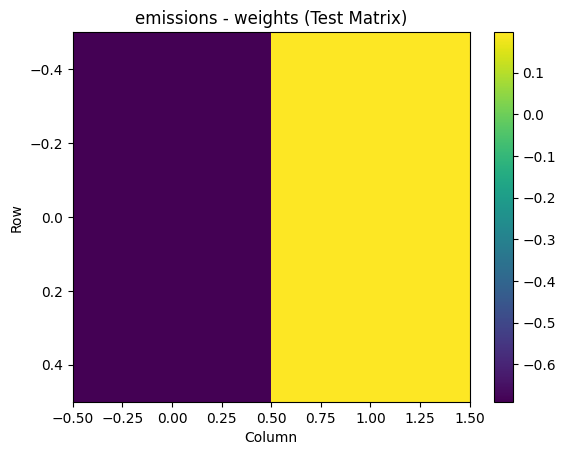

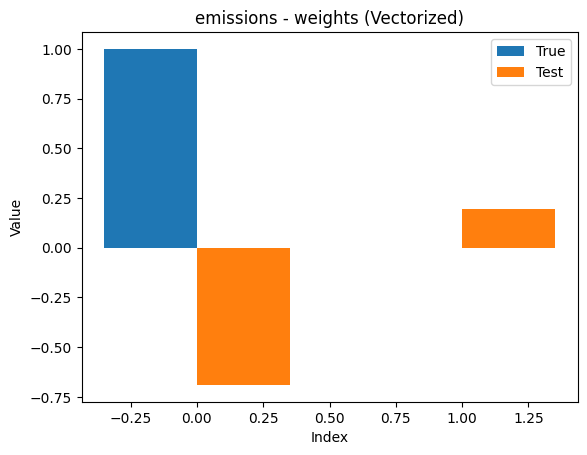

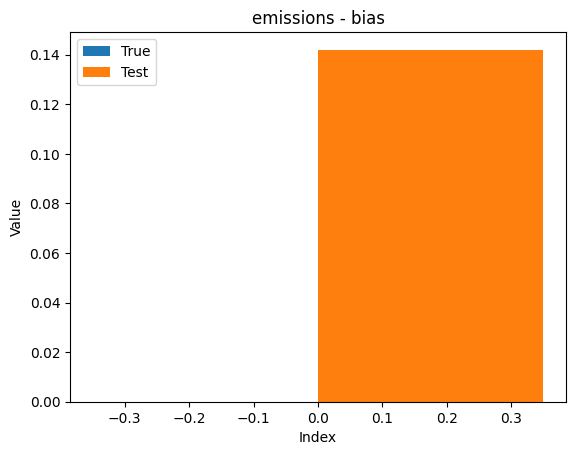

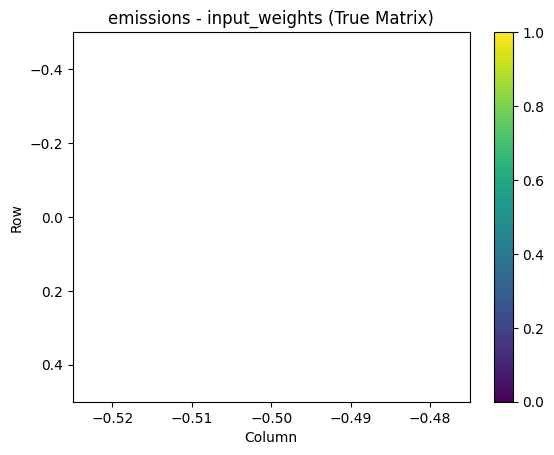

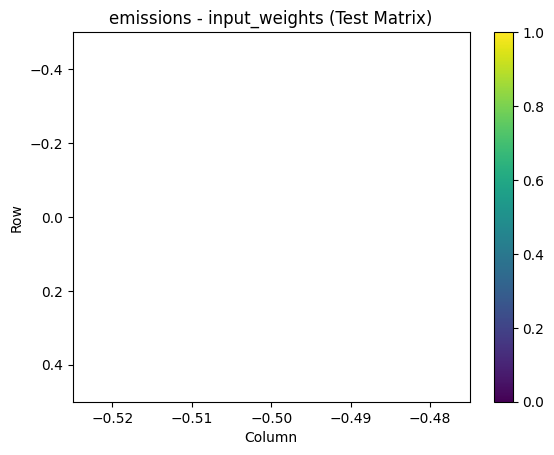

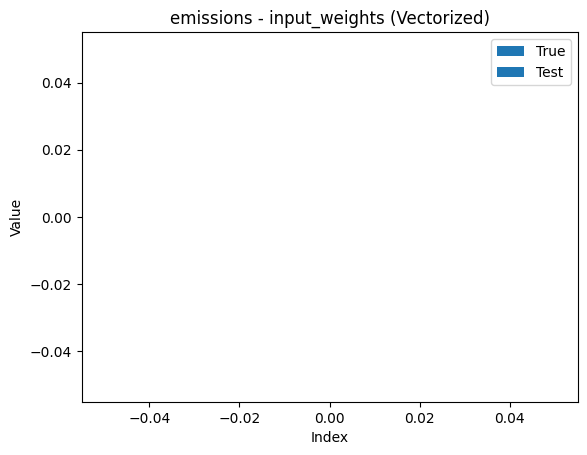

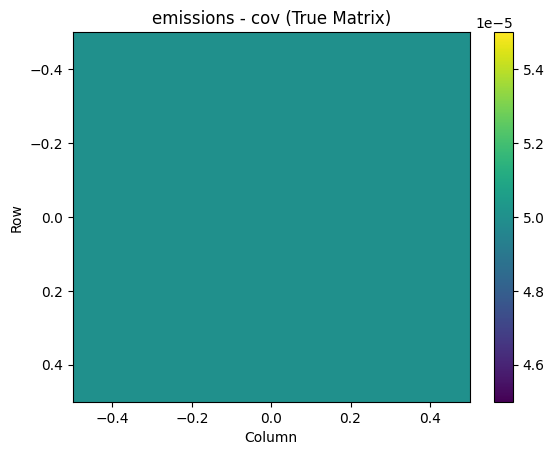

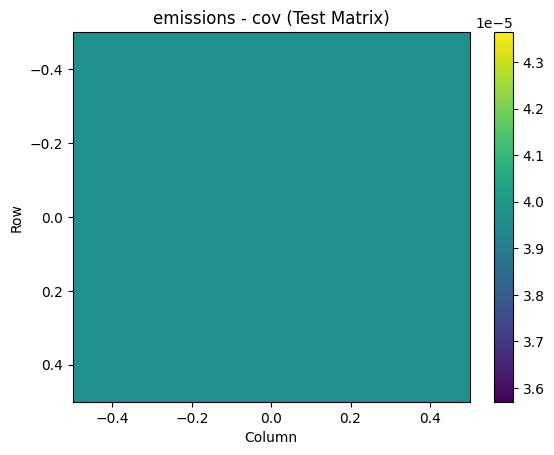

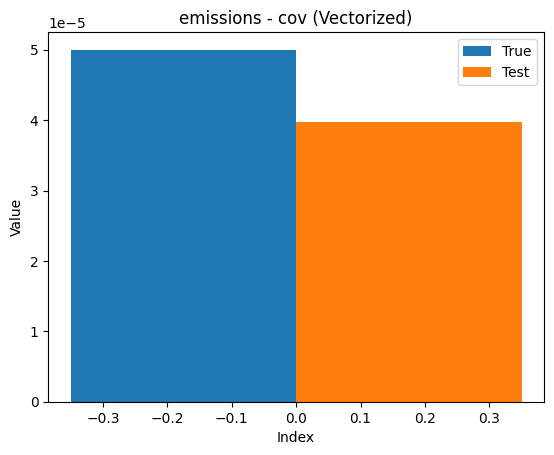

In [16]:
plot_learning_curve(
    marginal_lls,
    true_model,
    true_params,
    test_model,
    fitted_params,
    emissions,
    t_emissions,
)
filtered_posterior=test_model.filter(fitted_params,emissions=emissions,t_emissions=t_emissions)
plot_states(
    true_states,
    filtered_posterior.filtered_means,
    filtered_posterior.filtered_covariances,
    t_emissions,
)
plot_predictions(
    true_model,
    true_params,
    test_model,
    fitted_params,
    emissions,
    t_emissions
)
compare_parameters(
    true_params,
    fitted_params
)

## HMC for MAP estimation

### Auxiliary functions for later use

In [17]:
def plot_param_distributions(samples, true, sgd, name='', burn_in_frac=0.5):
    """
    Plots N_params horizontal box plots for the given N_params x N_samples matrix.

    Parameters:
    - samples: N_params x N_samples matrix of parameter samples.
    - true: N_params array of true parameter values.
    - sgd: N_params array of SGD estimates.
    - name: Name of the parameter set.
    - burn_in_frac: Fraction of samples to discard as burn-in.

    Returns:
    - A matplotlib figure with N_params horizontal box plots.
    """
    N_params = samples.shape[0]
    fig, ax = plt.subplots(figsize=(10, N_params * 2))  # Adjust figure size based on number of parameters

    # apply burn-in
    burn_in = int(burn_in_frac * samples.shape[1])
    samples = samples[:, burn_in:]
    
    # Create box plots
    ax.boxplot(samples, vert=False, patch_artist=True)

    # Set the y-axis labels to show parameter indices
    ax.set_yticks(range(1, N_params + 1))
    ax.set_yticklabels(["Parameter {}".format(i + 1) for i in range(N_params)])

    # Plot ground truth and estimates
    ax.scatter(sgd, range(1, N_params + 1), color="magenta", marker="o", s=100, label="Initial Estimate", zorder=3)
    ax.scatter(true, range(1, N_params + 1), color="red", marker="x", s=100, label="Ground Truth", zorder=4)

    plt.xlabel("Value")
    plt.ylabel("Parameters")
    plt.title("{} Parameter Distributions".format(name))
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_all(param_samples, true_params, init_params, burn_in_frac=0.5):
    """
    Plots the posterior distributions of all parameters.
    Burn-in is removed from the samples.
    """
    plot_param_distributions(
        param_samples.initial.mean.T, true_params.initial.mean, init_params.initial.mean, name="Initial mean",
        burn_in_frac=burn_in_frac
    )
    plot_param_distributions(
        param_samples.initial.cov.reshape(param_samples.initial.cov.shape[0], -1).T,
        true_params.initial.cov.flatten(),
        init_params.initial.cov.flatten(),
        name="Initial cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.weights.reshape(param_samples.dynamics.weights.shape[0], -1).T,
        true_params.dynamics.weights,
        init_params.dynamics.weights,
        name="Dynamics weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.bias.reshape(param_samples.dynamics.bias.shape[0], -1).T,
        true_params.dynamics.bias,
        init_params.dynamics.bias,
        name="Dynamics bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.dynamics.diffusion_cov.reshape(param_samples.dynamics.diffusion_cov.shape[0], -1).T,
        true_params.dynamics.diffusion_cov.flatten(),
        init_params.dynamics.diffusion_cov.flatten(),
        name="Dynamics diffusion cov",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.weights.reshape(
            param_samples.emissions.weights.shape[0], -1
        ).T,
        true_params.emissions.weights.flatten(),
        init_params.emissions.weights.flatten(),
        name="Emissions function weights",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.bias.reshape(
            param_samples.emissions.bias.shape[0], -1
        ).T,
        true_params.emissions.bias.flatten(),
        init_params.emissions.bias.flatten(),
        name="Emissions function bias",
        burn_in_frac=burn_in_frac,
    )
    plot_param_distributions(
        param_samples.emissions.cov.reshape(param_samples.emissions.cov.shape[0], -1).T,
        true_params.emissions.cov.flatten(),
        init_params.emissions.cov.flatten(),
        name="Emissions cov",
        burn_in_frac=burn_in_frac,
    )

## Define model to fit, and use HMC for MAP estimation

In [18]:
# Define new model, with different key seeding
HMC_model = MySSM(state_dim, emission_dim)
key = jr.PRNGKey(42)
HMC_init_params, HMC_param_props = HMC_model.initialize(key)

# HMC optimizer
hmc_samples = 500
hmc_warmup = 100
hmc_integration_steps=30

In [19]:
# Run HMC: initialized at randomly initialized parameters
param_samples, lps = HMC_model.fit_hmc(
    HMC_init_params,
    param_props,
    emissions,
    t_emissions=t_emissions,
    filter_hyperparams=None,
    num_samples=hmc_samples,
    warmup_steps=hmc_warmup,
    num_integration_steps=hmc_integration_steps,
)

Running window adaptation


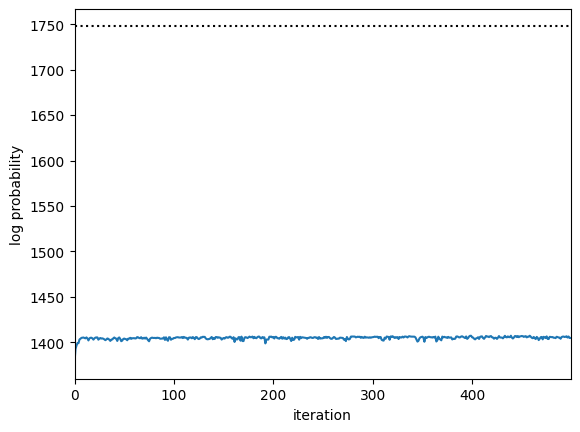

In [20]:
# Log-probability plot over iteration-samples
plt.plot(lps)
true_logjoint = (
        true_model.log_prior(true_params) \
            + true_model.marginal_log_prob(
                true_params,
                emissions,
                t_emissions)
)
plt.axhline(true_logjoint, color = 'k', linestyle = ':', label="true")
plt.xlabel("iteration")
plt.ylabel("log probability")
plt.autoscale(enable=True, axis="x", tight=True)

In [21]:
# Compute filtered posteriors, for all samples
filtered_posteriors = vmap(
    partial(
        HMC_model.filter,
        emissions=emissions,
        t_emissions=t_emissions
    )
    )(param_samples)

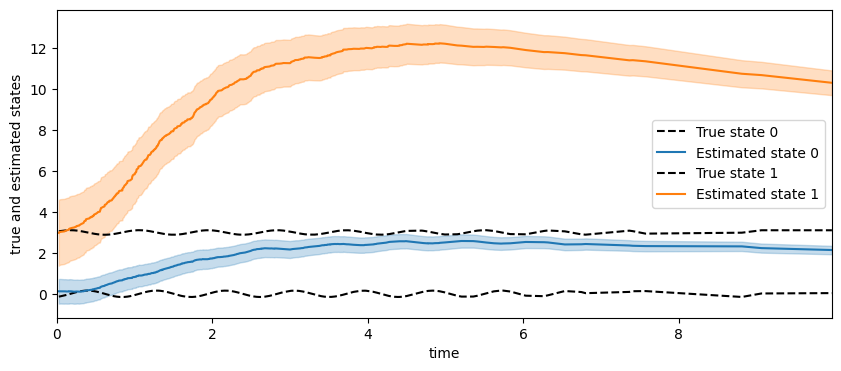

In [22]:
# Average over per-sample posterior filtered stats
filtered_mean = filtered_posteriors.filtered_means.mean(axis=0)
filtered_cov = filtered_posteriors.filtered_covariances.mean(axis=0)
# Plot average
plot_states(
    true_states,
    filtered_mean,
    filtered_cov,
    t_emissions,
)

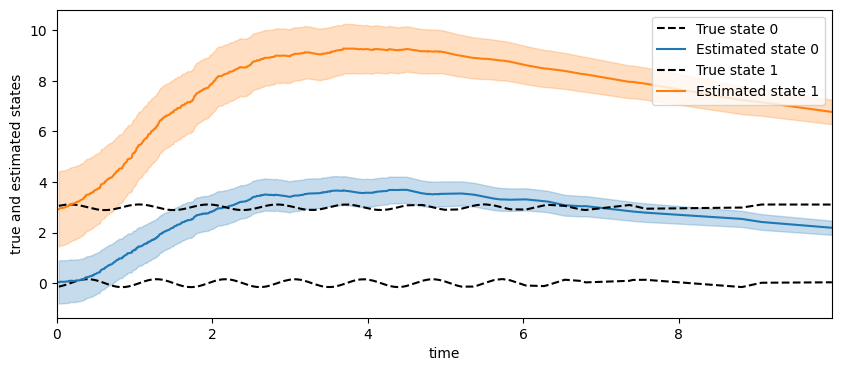

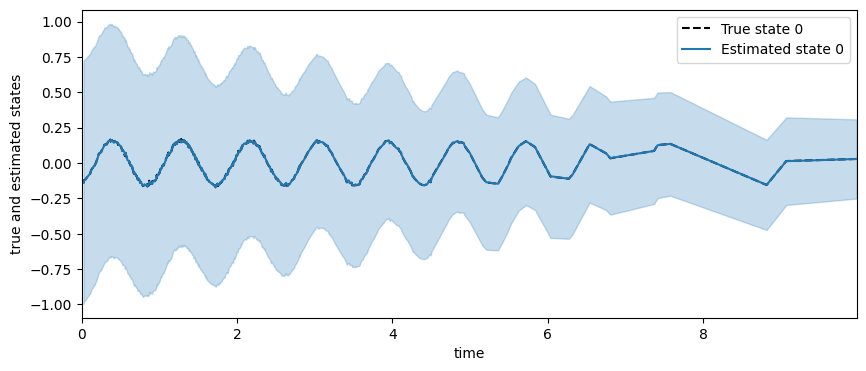

In [23]:
# Average over per-sample posterior filtered stats
# Plot average
n_sample=499
plot_states(
    true_states,
    filtered_posteriors.filtered_means[n_sample],
    filtered_posteriors.filtered_covariances[n_sample],
    t_emissions,
)
plot_states(
    emissions,
    filtered_posteriors.filtered_means[n_sample]@param_samples.emissions.weights[n_sample].T + param_samples.emissions.bias[n_sample],
    filtered_posteriors.filtered_covariances[n_sample],
    t_emissions,
)

In [24]:
@jit
def filter_emission(params, filtered_posterior):
    C = params.emissions.weights
    d = params.emissions.bias
    return filtered_posterior.filtered_means @ C.T + d

In [25]:
filtered_emissions = vmap(filter_emission)(param_samples, filtered_posteriors)
filtered_emissions_mean = filtered_emissions.mean(axis=0)
filtered_emissions_std = jnp.std(filtered_emissions, axis=0)

# note that this shows a distribution of filtered means
# Unlike earlier plots, it does not show the filtered covariances, 
# which would add an appearance of greater uncertainty.
print([emissions.shape, filtered_emissions.shape, filtered_emissions_mean.shape, filtered_emissions_std.shape])

[(500, 1), (500, 500, 1), (500, 1), (500, 1)]


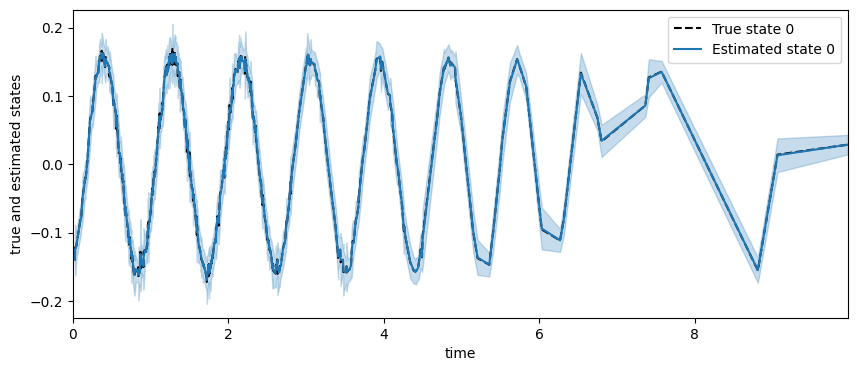

In [26]:
# We use states function, but we are plotting averaged emissions
plot_states(
    emissions,
    filtered_emissions_mean,
    filtered_emissions_std[...,None],
    t_emissions,
)

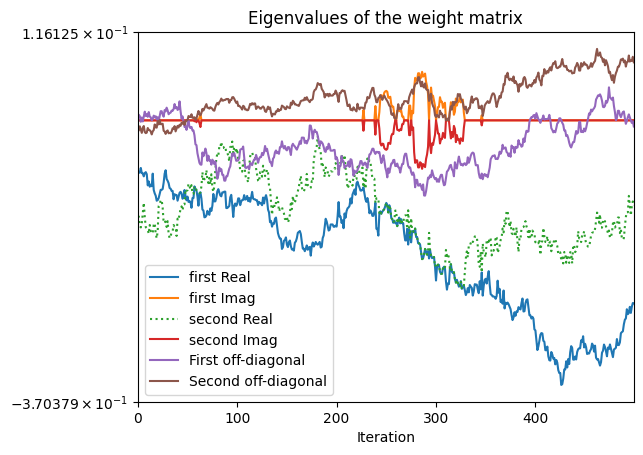

In [27]:
# compute eigenvalues of param_samples.dynamics.drift.params across samples using vmap
eigvals = vmap(jnp.linalg.eigvals)(param_samples.dynamics.weights)

# plot the complex part of the eigenvalues
plt.plot(eigvals.real[:, 0], '-', label="first Real")
plt.plot(eigvals.imag[:, 0], label="first Imag")
plt.plot(eigvals.real[:, 1], ':', label="second Real")
plt.plot(eigvals.imag[:, 1], label="second Imag")
plt.plot(param_samples.dynamics.weights[:, 1, 0], label="First off-diagonal")
plt.plot(param_samples.dynamics.weights[:, 0, 1], label="Second off-diagonal")
plt.yscale("symlog")
plt.xlabel("Iteration")
plt.legend()
plt.title("Eigenvalues of the weight matrix")
plt.autoscale(enable=True, axis="x", tight=True)

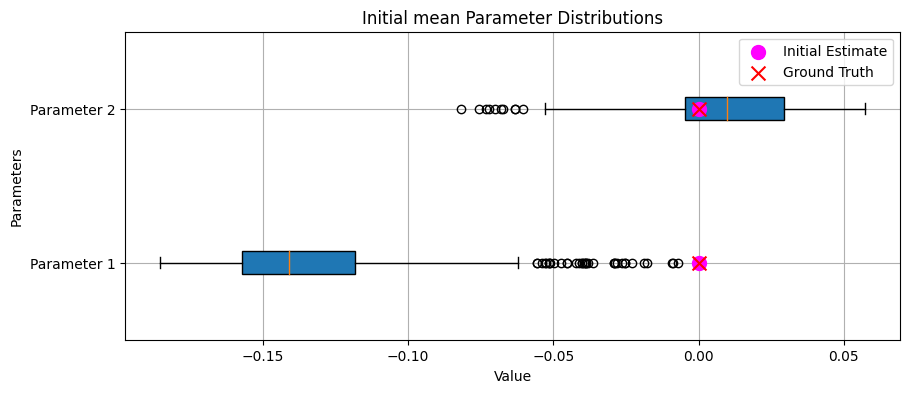

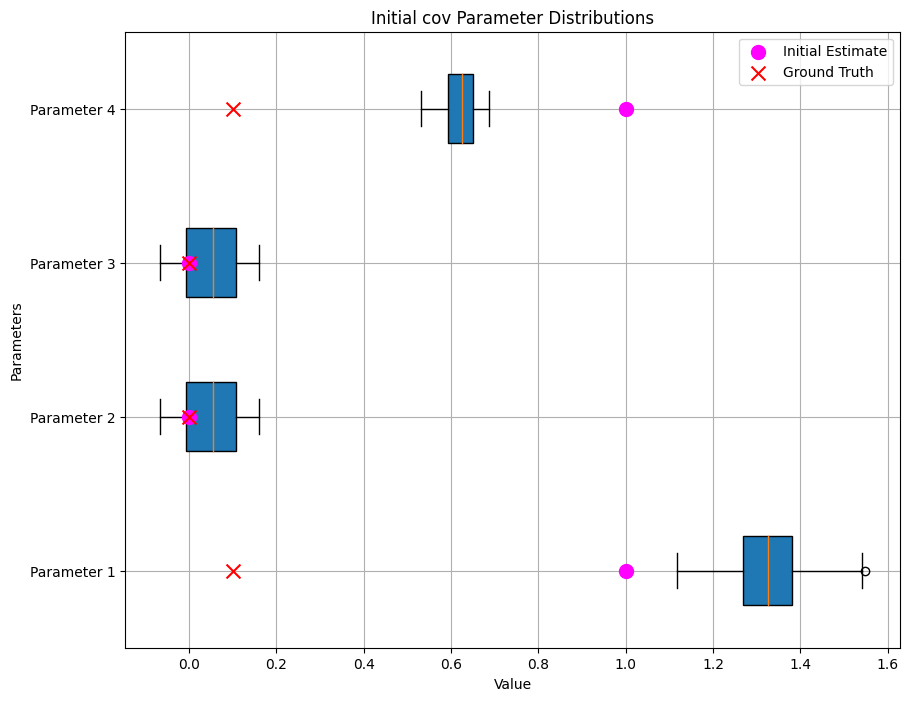

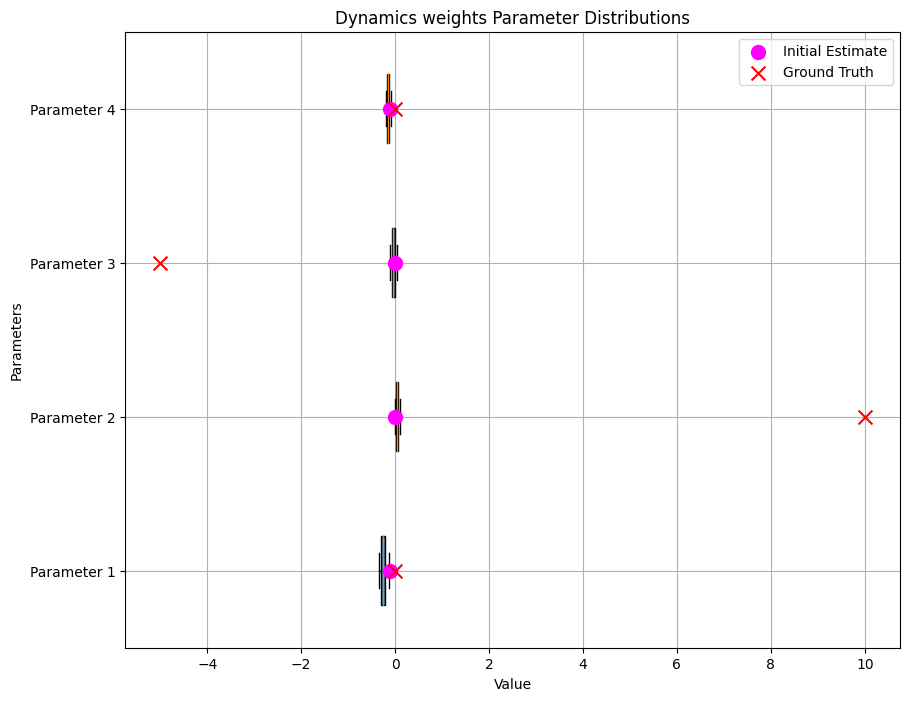

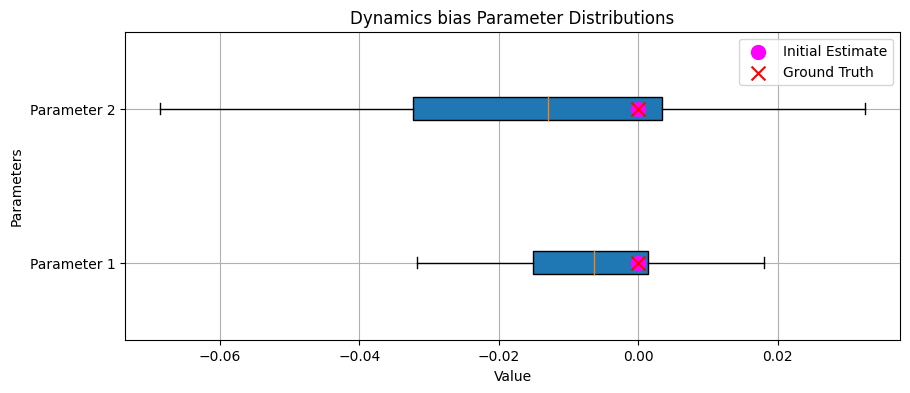

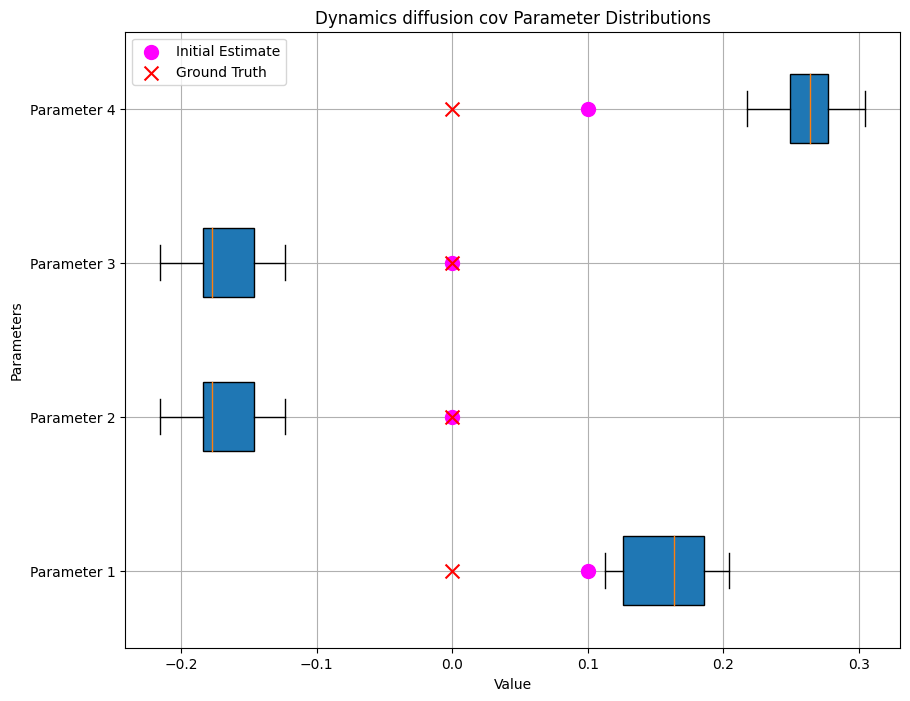

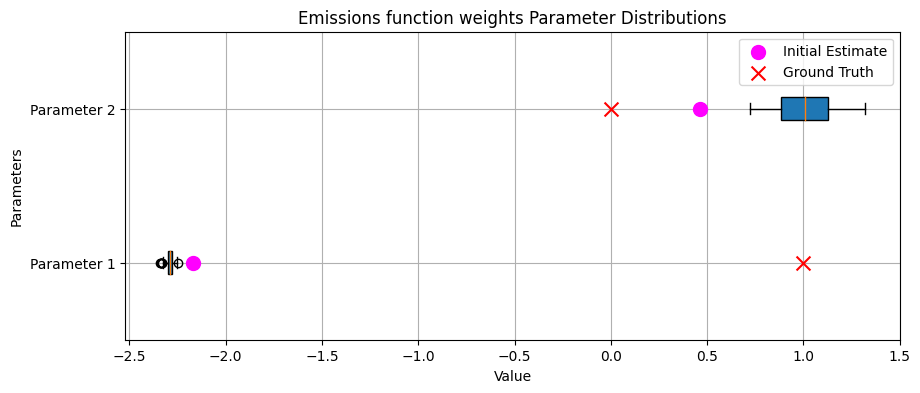

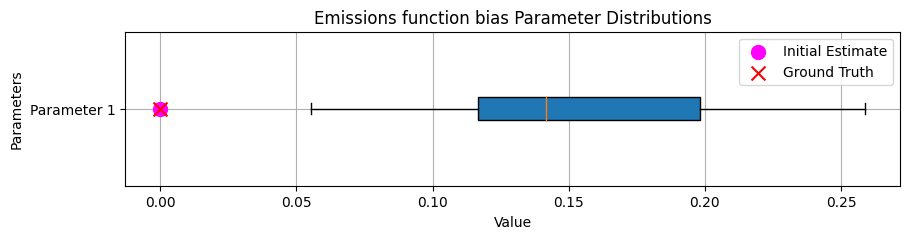

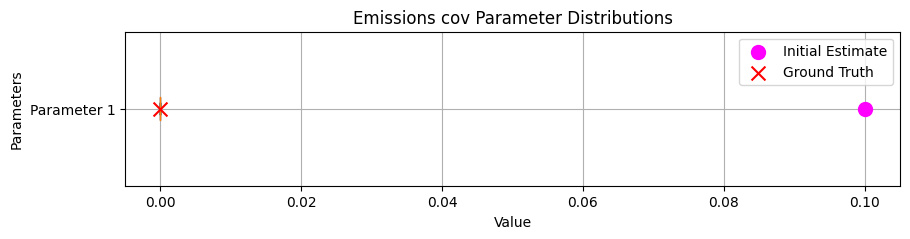

In [28]:
plot_all(
    param_samples,
    true_params,
    HMC_init_params
)